## 0.0 Imports

In [1]:
import pandas as pd
import inflection
import math
import numpy as np

import seaborn as sns

import pickle


from boruta import BorutaPy
from scipy import stats as ss
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.core.display import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

0.1 Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; } </style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

    
def cramer_v(x, y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold + 1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # define beggining and end of validation date:
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k * 6 * 7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k - 1) * 6 * 7)
        
        #filter the dataset:
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]
        
        #training:
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']
        
        #validation
        xvalidation = validation.drop(['date','sales'], axis = 1)
        yvalidation = validation['sales']
        
        #model
        m = model.fit(xtraining, ytraining)
        
        #prediction
        yhat = m.predict(xvalidation)
        
        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        #store performance
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame( {'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str),


                         },index = [0])

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


Loading Data / files

In [3]:
df4 = pd.read_pickle('./03.pkl')
num_types = pd.read_pickle('./2 - num_types')
cat_types = pd.read_pickle('./2 - cat_types')

 # 4.0 Exploratory Data Analysis

4.1 Univariate Analysis

4.1.1 Response Variable

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

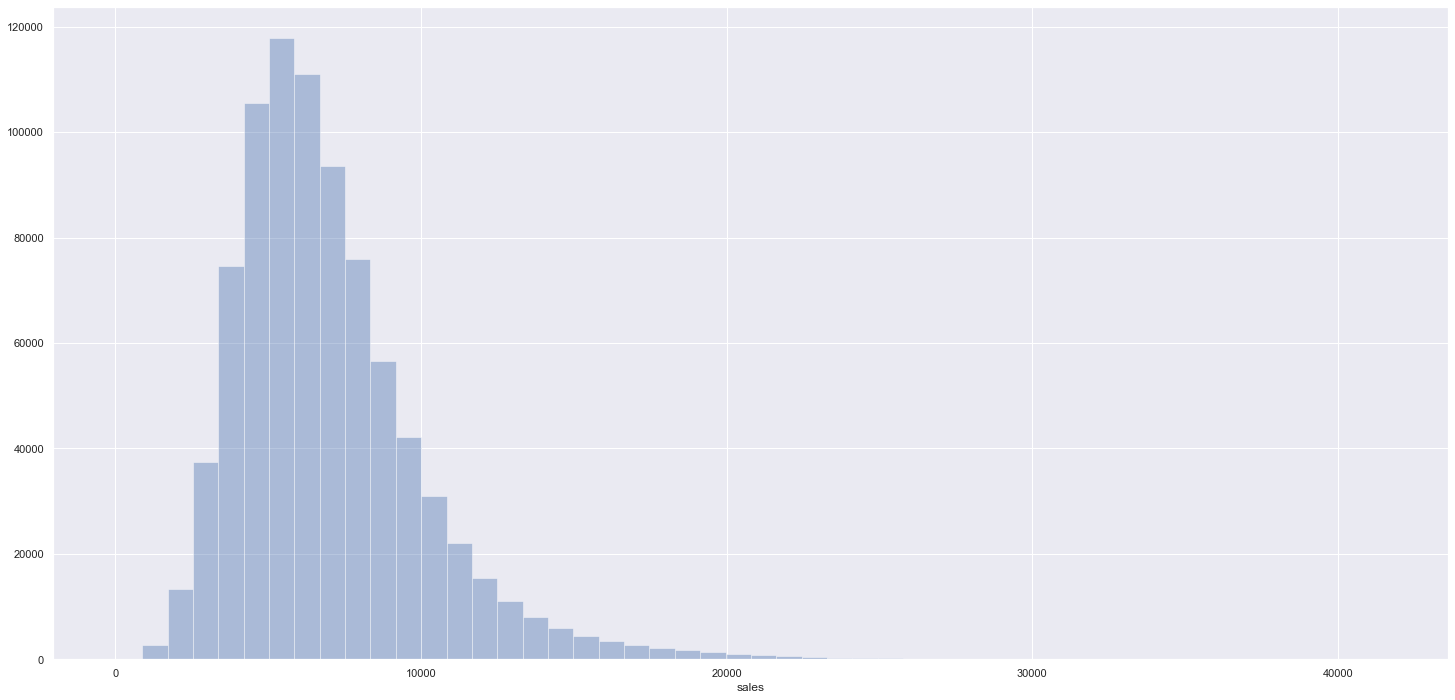

In [4]:
sns.distplot(df4['sales'], kde = False)

4.1.2 - Numerical Variable

array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'promo_interval'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

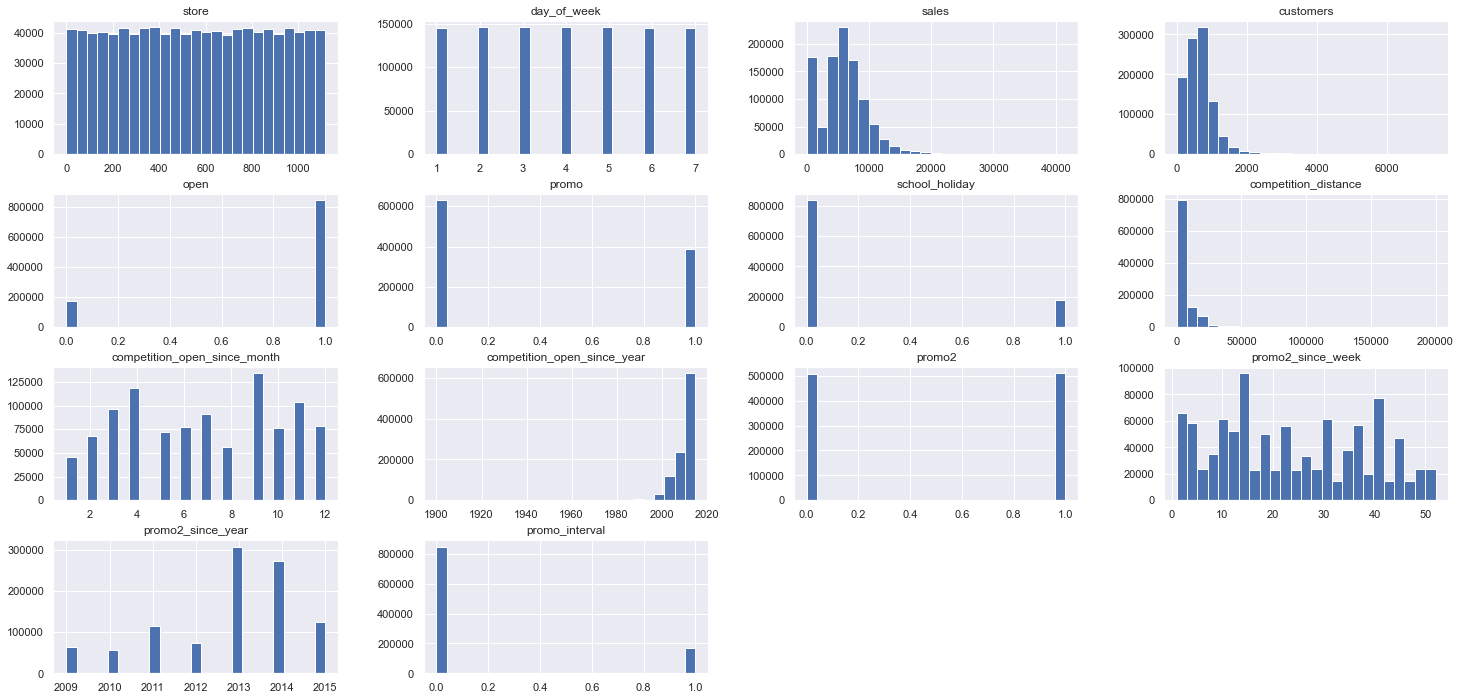

In [5]:
num_types.hist(bins = 25)

4.1.3 Categorical Variable

['regular_day' 'public_holiday' 'easter_holiday' 'chritsmas']


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

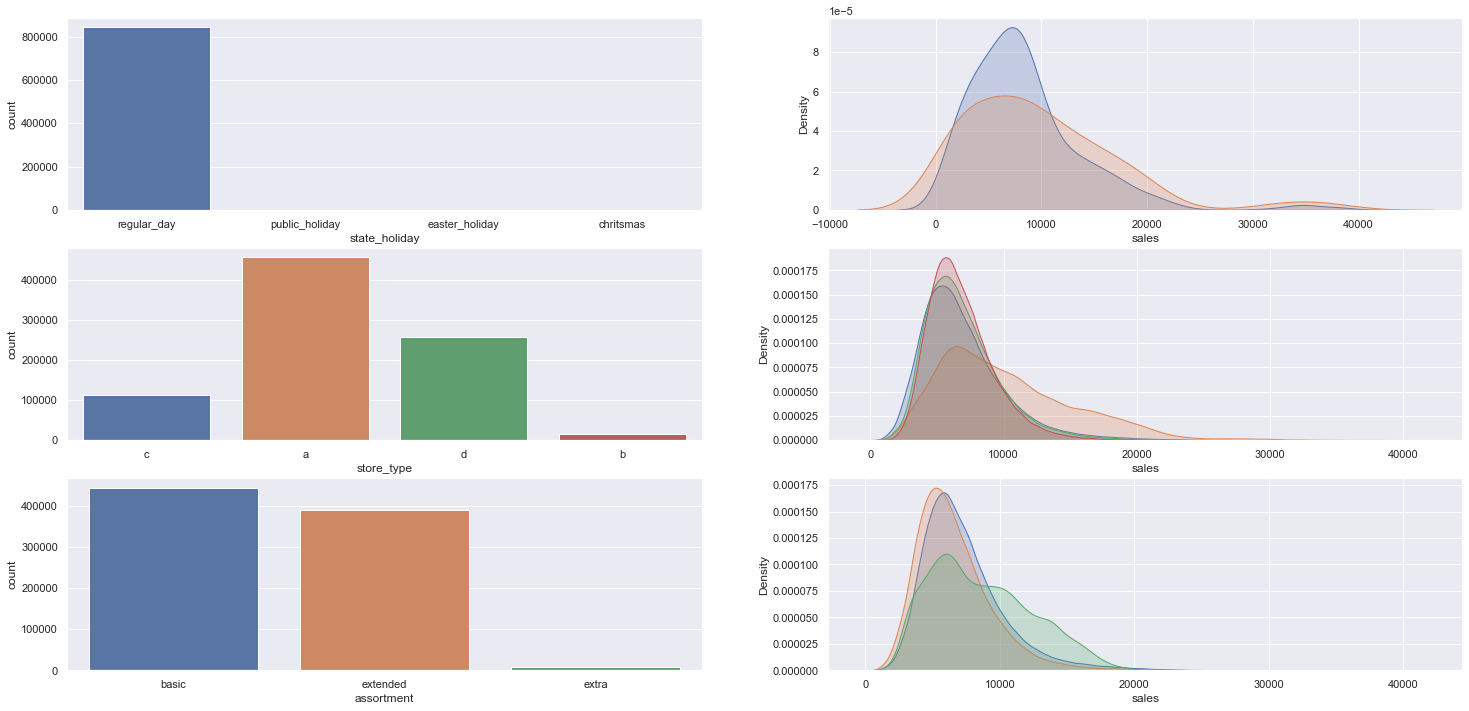

In [6]:
# state holiday
# counting
print(df4['state_holiday'].unique())
plt.subplot(3,2,1)
aa = df4[df4['state_holiday'] != 'regular day']
sns.countplot(aa['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'chrismas']['sales'], label = 'public_holiday', shade = True)

# store type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)

# assortments
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)

4.2 - Analise Bivariada

1 - Stores with more sortment items should sell more.

2 - Stores with more nearby competitors sell less.

3 - Stores with competetors from long date sell more.

4 - Stores with active promotions for more time sell more.

5 - Stores with less promotion days sell more.

6 -

7 - Stores with more consecutive promotions sell more.

8 - Stores open on Chrimas sell more

9 - Stores shouls sell more the throughout the years.

10 - Stores should sell more at the 2nd semester.

11 - Stores sell more after the 10th on each month.

12 - Stores sell less on weekends.

13 - Stores sell less during school holidays.


In [7]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'year', 'month', 'day',
       'week_of_year', 'year_week', 'competition_since',
       'competition_length_months', 'promo_since', 'promo_time_week'],
      dtype='object')

H1 - Stores with more sortment sell more.

In [8]:
df4.assortment.unique()

array(['basic', 'extended', 'extra'], dtype=object)

<AxesSubplot:xlabel='year_week'>

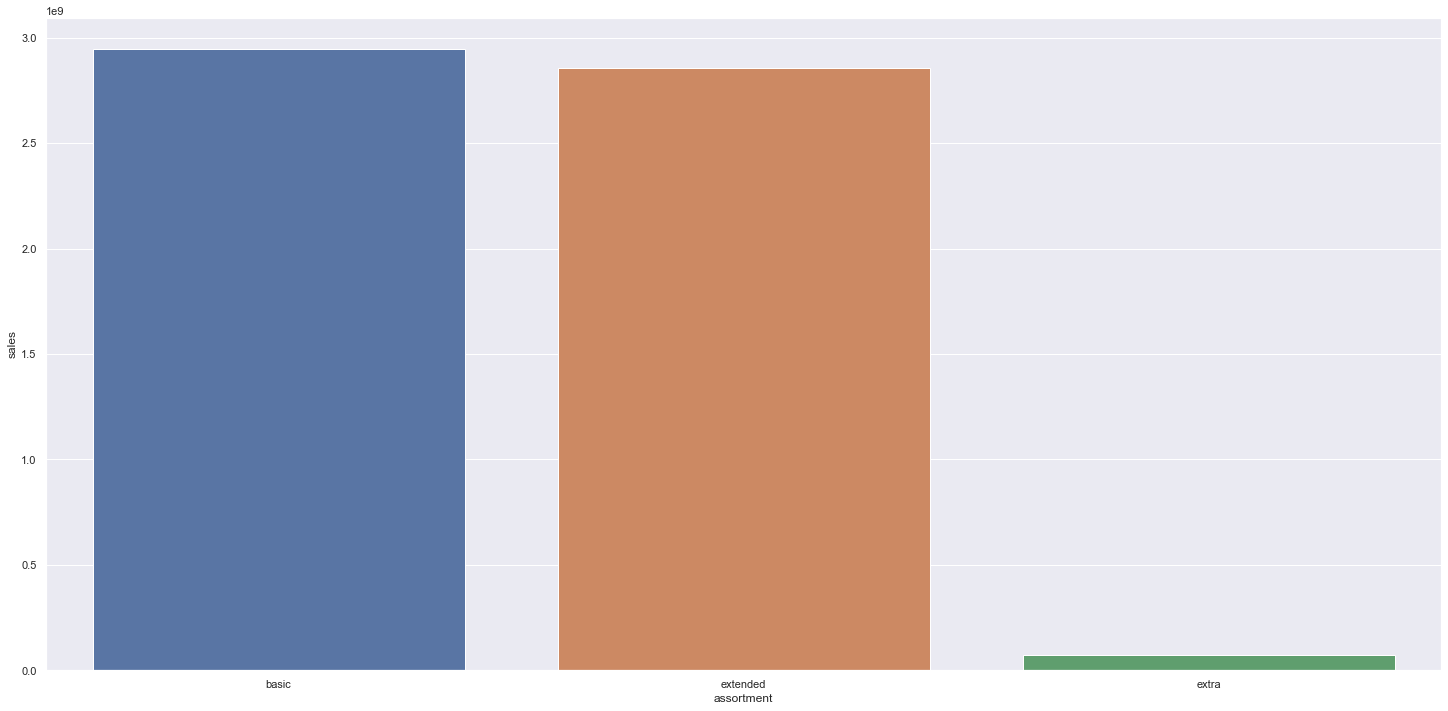

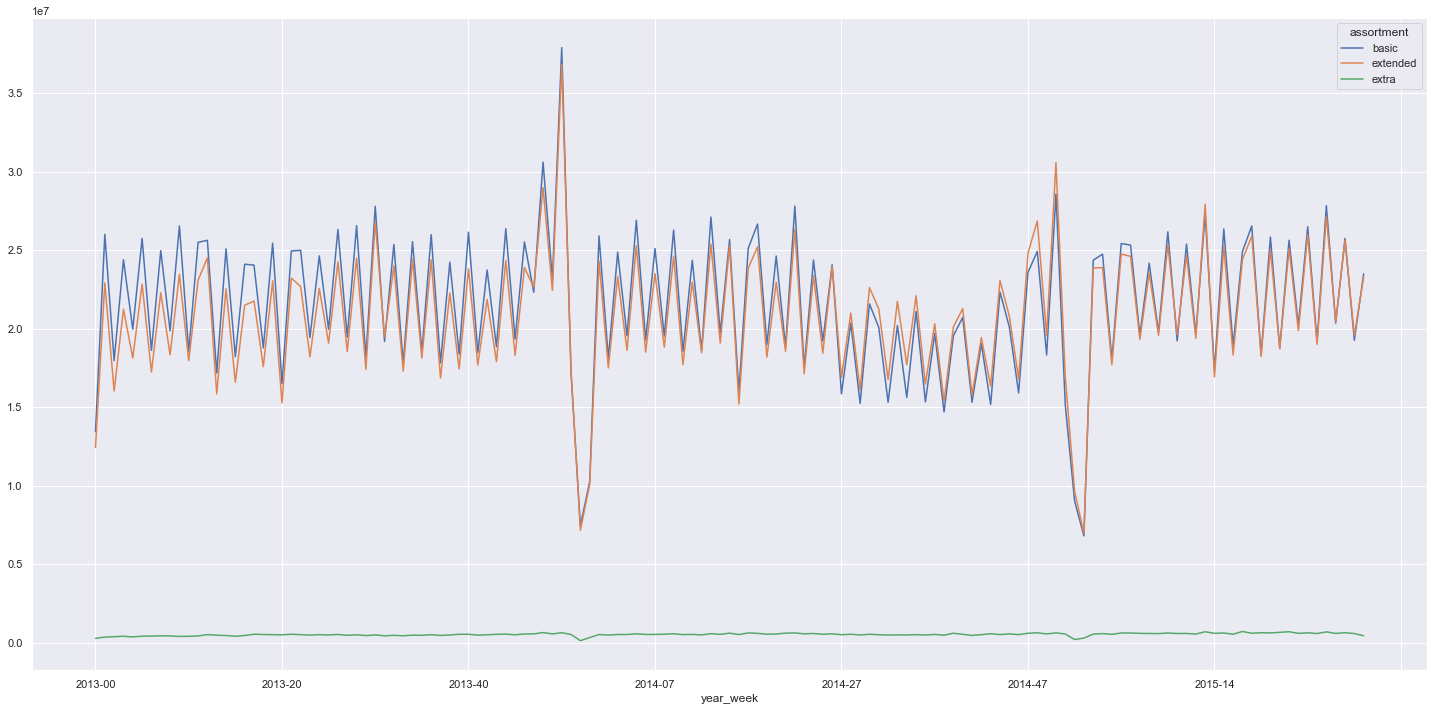

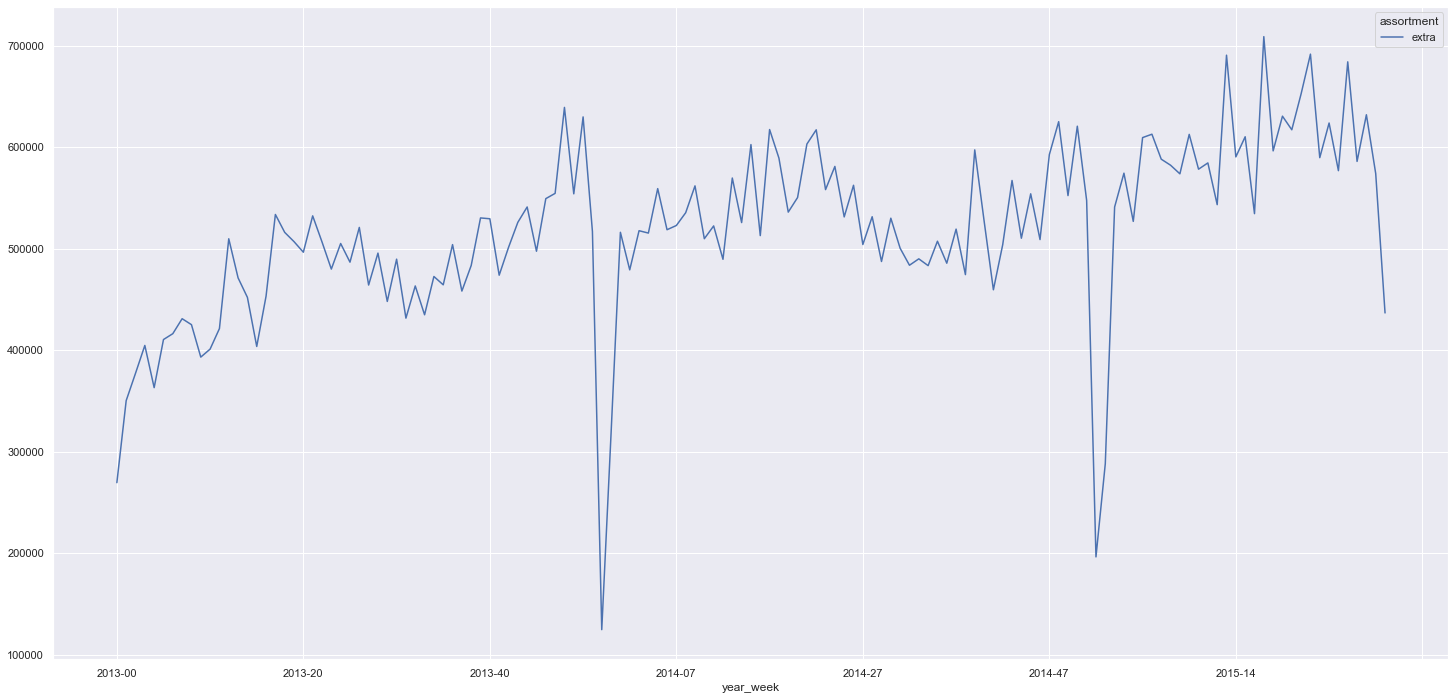

In [9]:
# plt.subplot(1,3,1)
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1)

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

aux3 = df4[df4['assortment'] == 'extra'].groupby(['year_week', 'assortment']).sum().reset_index()
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

H2 - Stores with more competitors nearby might sell less.

<AxesSubplot:>

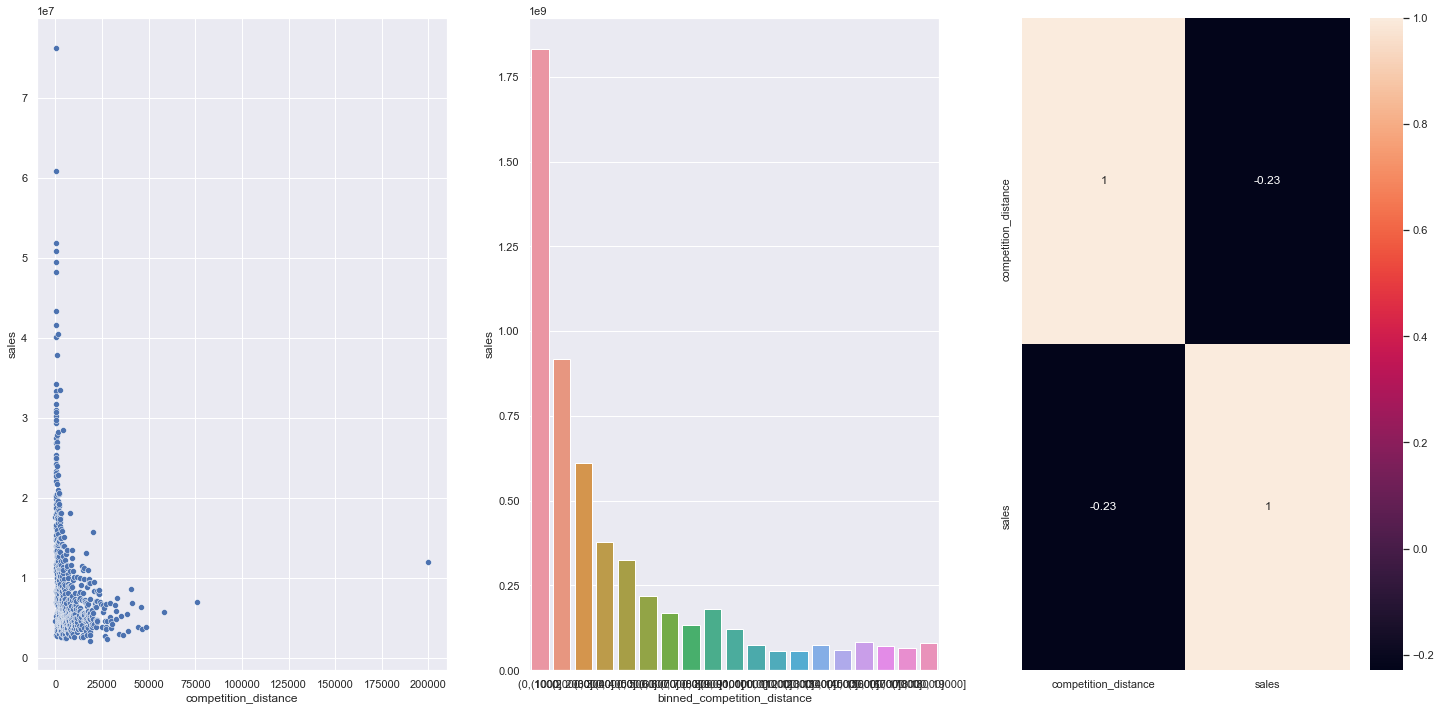

In [10]:
df4.columns

aux1 = df4[['sales', 'competition_distance']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)

#Lets Bin the barplot

bins = list(range(0,20000,1000))
aux1['binned_competition_distance'] = pd.cut(aux1['competition_distance'], bins=bins)

aux2 = aux1[['sales','binned_competition_distance']].groupby('binned_competition_distance').sum().reset_index()
plt.subplot(1,3,2)
sns.barplot(x = 'binned_competition_distance', y = 'sales', data = aux2)

# heat map for correlation
plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True)


H3 - Stores with long time competitors should sell more.

In [11]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'year', 'month', 'day',
       'week_of_year', 'year_week', 'competition_since',
       'competition_length_months', 'promo_since', 'promo_time_week'],
      dtype='object')

In [12]:
df4.competition_length_months.unique()

array([  84,   94,  105,   71,    4,   20,   28,   10,  182,   45,    1,
         17,   65,  117,   62,   76,  192,  121,  187,  150,  128,   18,
         37,   27,  180,  148,    8,  101,  107,   50,  120,   39,   96,
         69,   25,   16,   23,   12,  130,   41,   14,   88,   99,   70,
         93,   63,  115,   85,   68,  114,   73,  106,   53,   89,   46,
        127,   56,  119,  134,  143,    3,   75,   24,  145,   57,  191,
         47,   35,   66,   92,   61,  159,  154,  655,   81,  110,   54,
        131,   29,  118,  126,   77,  125,   13,   32,  139,   59,   90,
          5,  157,  155,  113,   30,   82,  241,   83,  169,   11,   43,
          2,  147,   15,  173,  124,  179,  100,   74,   33,  122,  168,
        170,   21,  174,   40,  129,  306,  137,   52,  144,   60,   36,
         48,    9,  175,   38,  146,  252,   78,  151,  108,  164,   86,
        161,  305,  166,  112,   79,   19,   98,  240,  123,  171,  194,
        104,   97,  111,  167,  142,   34,  116,   

<AxesSubplot:xlabel='competition_length_months', ylabel='sales'>

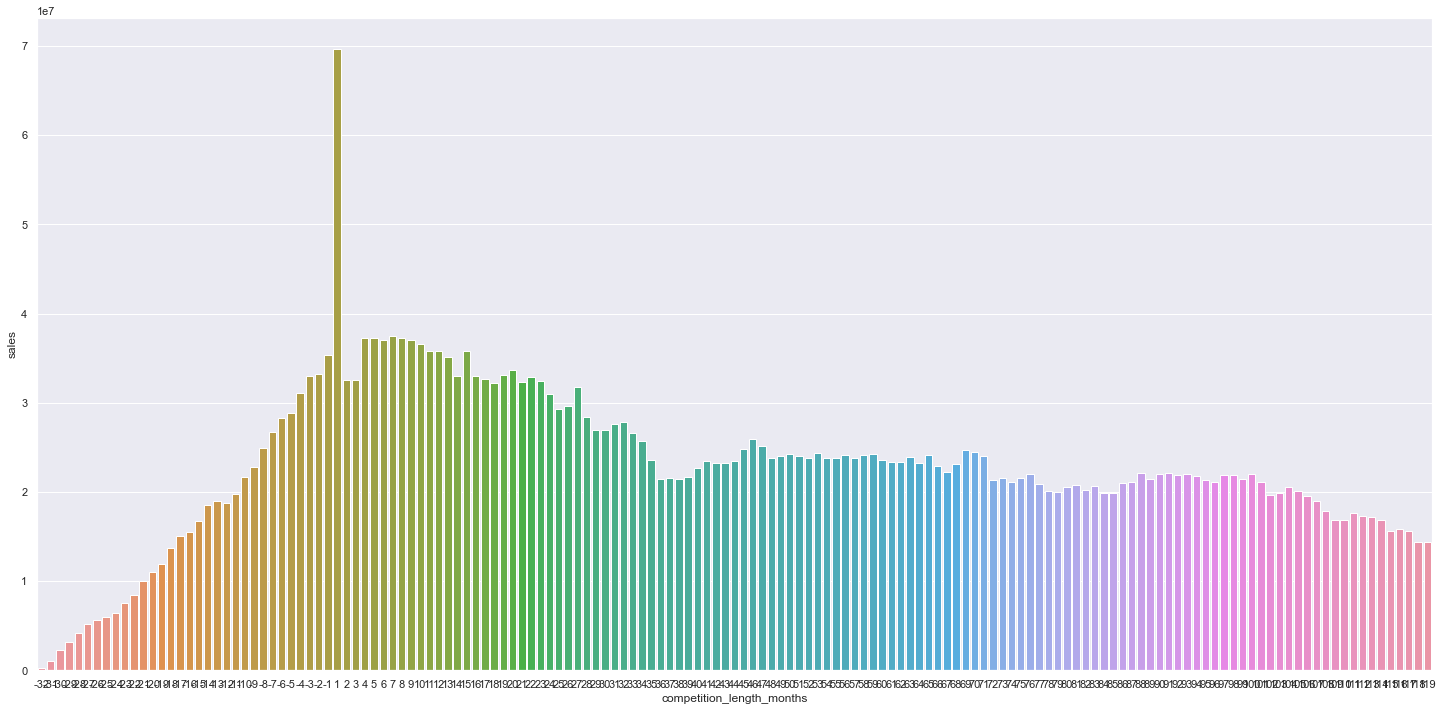

In [13]:

aux1 = df4[(df4['competition_length_months'] != 0) & (df4['competition_length_months'] < 120)]
aux1 = aux1[['competition_length_months', 'sales']].groupby('competition_length_months').sum().reset_index()

sns.barplot(x = 'competition_length_months', y = 'sales', data = aux1)

<AxesSubplot:xlabel='competition_length_months', ylabel='sales'>

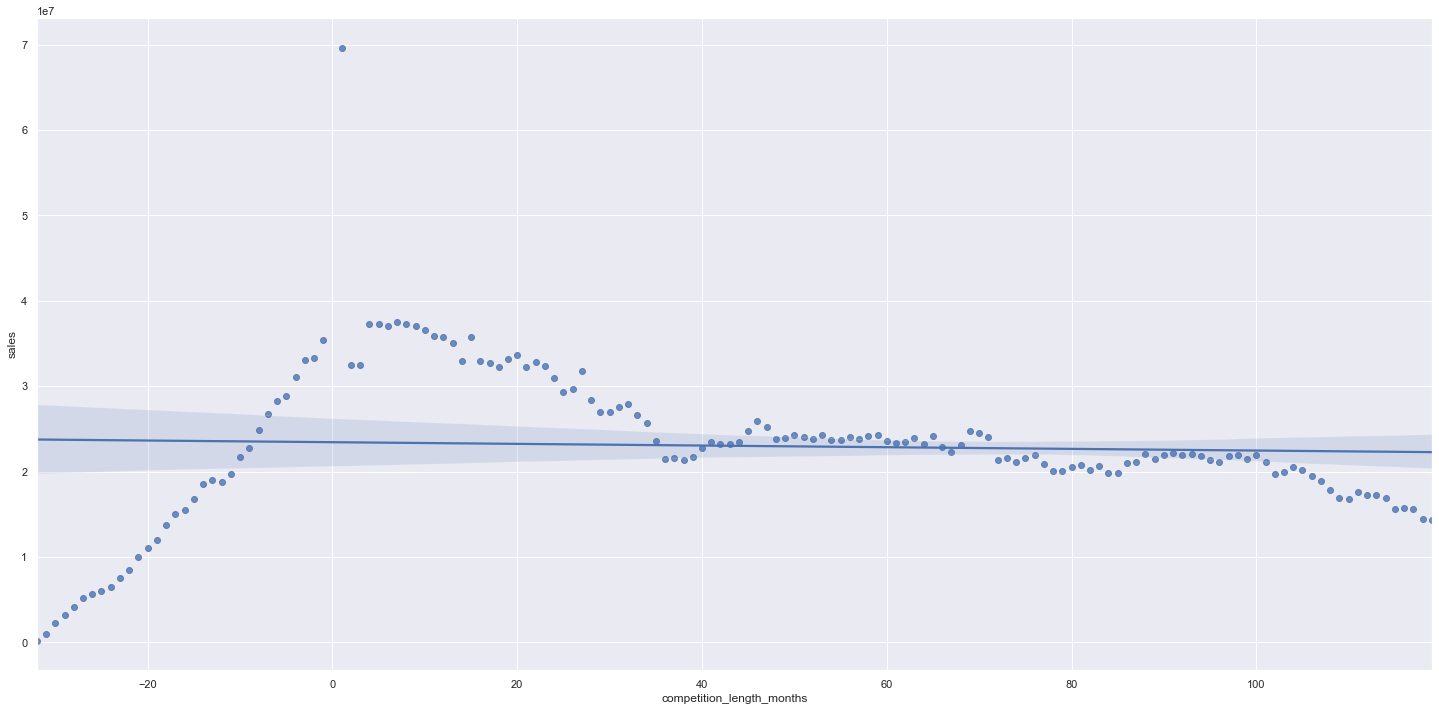

In [14]:
sns.regplot(data = aux1,x = 'competition_length_months', y = 'sales')# ,aspsokasosa=1221)

<AxesSubplot:>

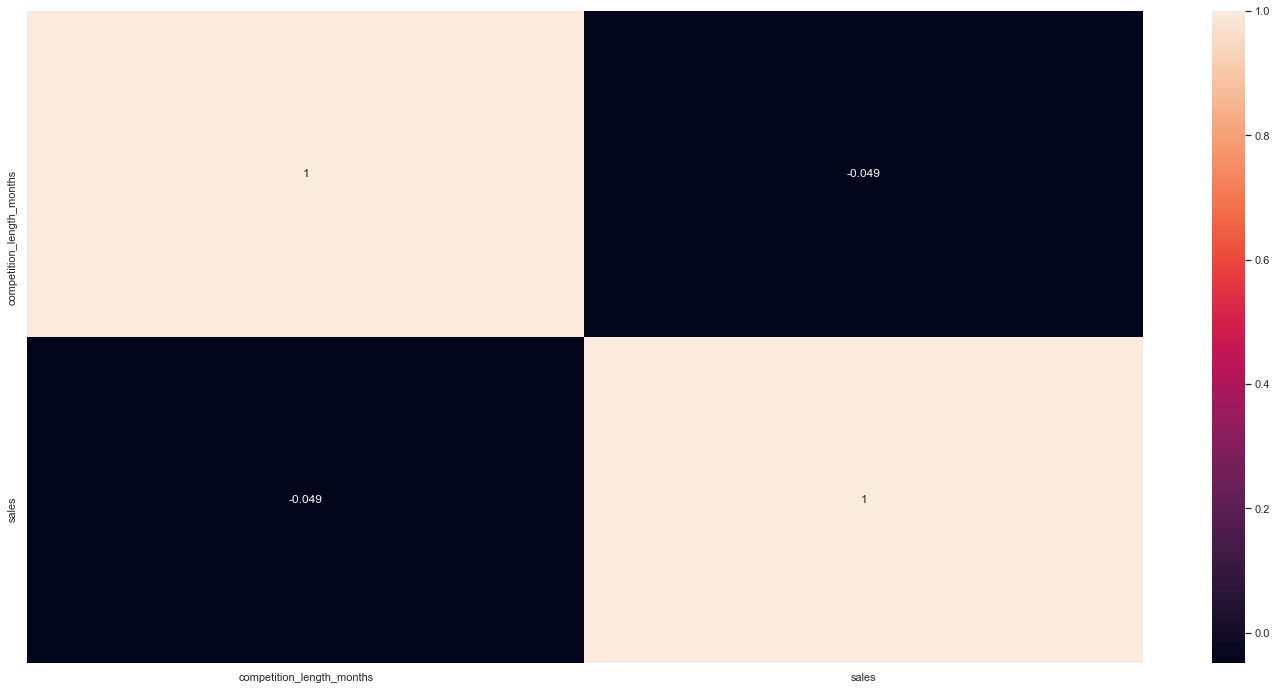

In [15]:
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

In [16]:
aux1.corr(method = 'pearson')

,competition_length_months,sales
competition_length_months,1.000000,-0.049301
sales,-0.049301,1.000000


H5 - Stores with more days of promotions should sell more.

H6 -

H7 - Stores with more consecutive promotions should sell more.

In [17]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'year', 'month', 'day',
       'week_of_year', 'year_week', 'competition_since',
       'competition_length_months', 'promo_since', 'promo_time_week'],
      dtype='object')

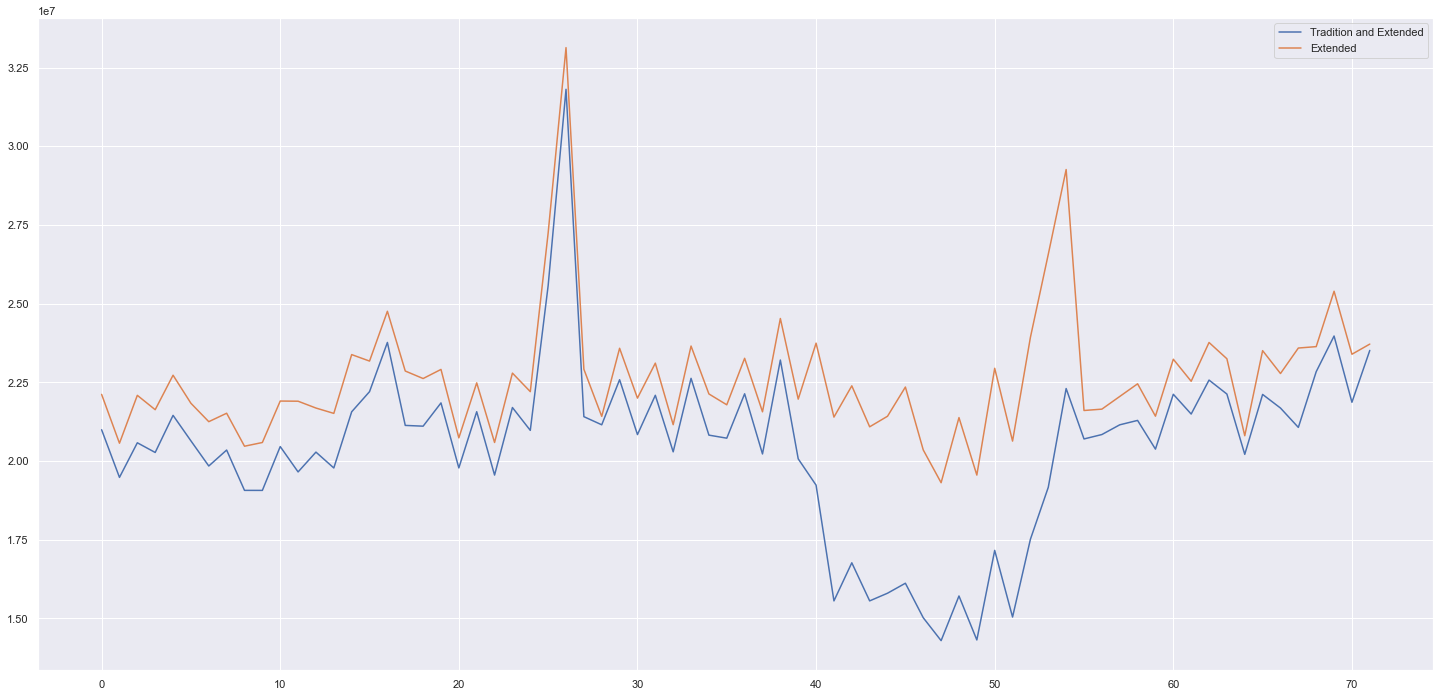

In [18]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()

aux2.plot( ax = ax)
ax.legend(labels = ['Tradition and Extended', 'Extended'])

H4 - Stores with promotion active for longer should sell more.

In [19]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'year', 'month', 'day',
       'week_of_year', 'year_week', 'competition_since',
       'competition_length_months', 'promo_since', 'promo_time_week'],
      dtype='object')

In [20]:
sort(list(df4['promo_time_week'].unique()))

array([-126, -125, -124, -123, -122, -121, -120, -119, -118, -117, -116,
       -115, -114, -113, -112, -111, -110, -109, -108, -107, -106, -105,
       -104, -103, -102, -101, -100,  -99,  -98,  -97,  -96,  -95,  -94,
        -93,  -92,  -91,  -90,  -89,  -88,  -87,  -86,  -85,  -84,  -83,
        -82,  -81,  -80,  -79,  -78,  -77,  -76,  -75,  -74,  -73,  -72,
        -71,  -70,  -69,  -68,  -67,  -66,  -65,  -64,  -63,  -62,  -61,
        -60,  -59,  -58,  -57,  -56,  -55,  -54,  -53,  -52,  -51,  -50,
        -49,  -48,  -47,  -46,  -45,  -44,  -43,  -42,  -41,  -40,  -39,
        -38,  -37,  -36,  -35,  -34,  -33,  -32,  -31,  -30,  -29,  -28,
        -27,  -26,  -25,  -24,  -23,  -22,  -21,  -20,  -19,  -18,  -17,
        -16,  -15,  -14,  -13,  -12,  -11,  -10,   -9,   -8,   -7,   -6,
         -5,   -4,   -3,   -2,   -1,    0,    1,    2,    3,    4,    5,
          6,    7,    8,    9,   10,   11,   12,   13,   14,   15,   16,
         17,   18,   19,   20,   21,   22,   23,   

<AxesSubplot:>

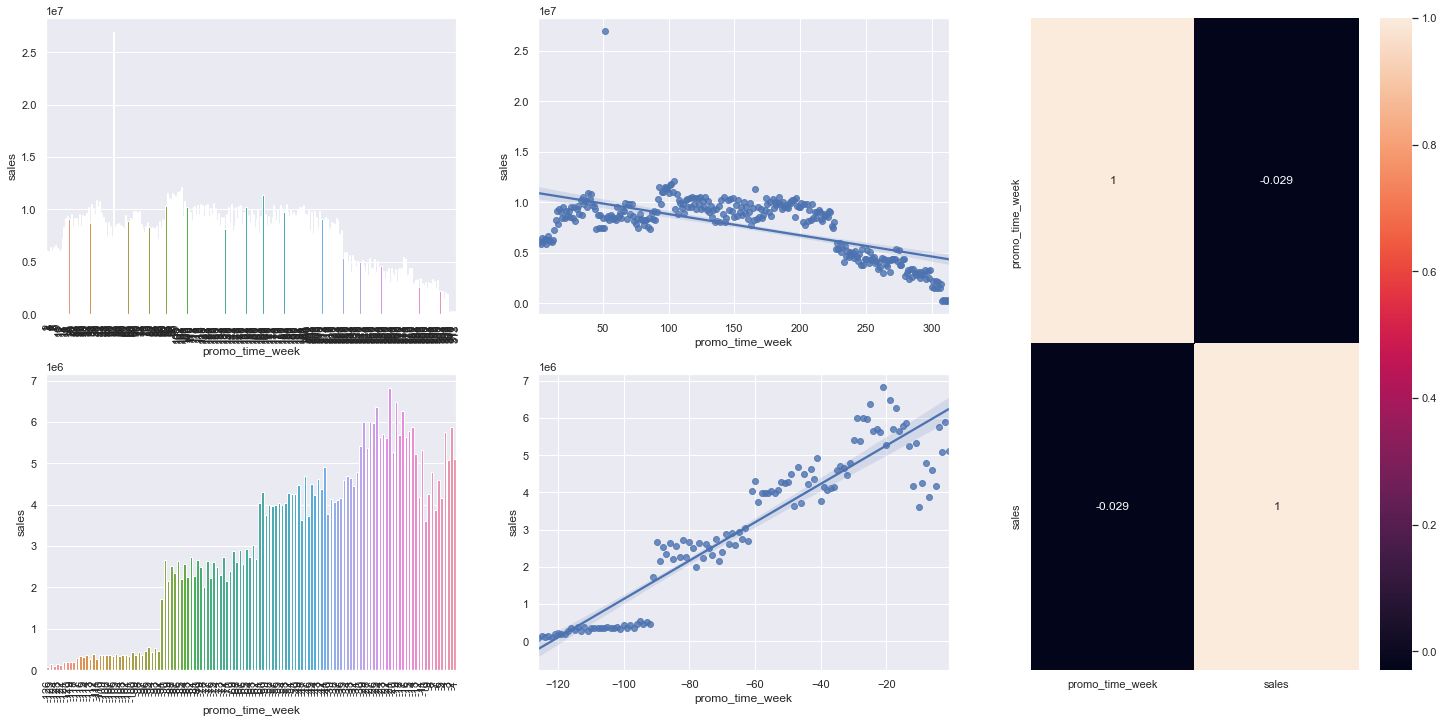

In [21]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])

aux2 = aux1[aux1['promo_time_week'] > 0] #extended promotion
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2)
plt.xticks(rotation = 90)

plt.subplot(grid[0,1])
sns.regplot(x= 'promo_time_week', y = 'sales', data = aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promotion time
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3)
plt.xticks(rotation = 90)

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)



H5 - Stores with more promotions days should sell more (IGNORED - review on 2nd CRISP cycle)

H7 - Stores with more consecutive promotions should sell more - if the store has entered a consecutive period

In [22]:
df4[['promo','promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


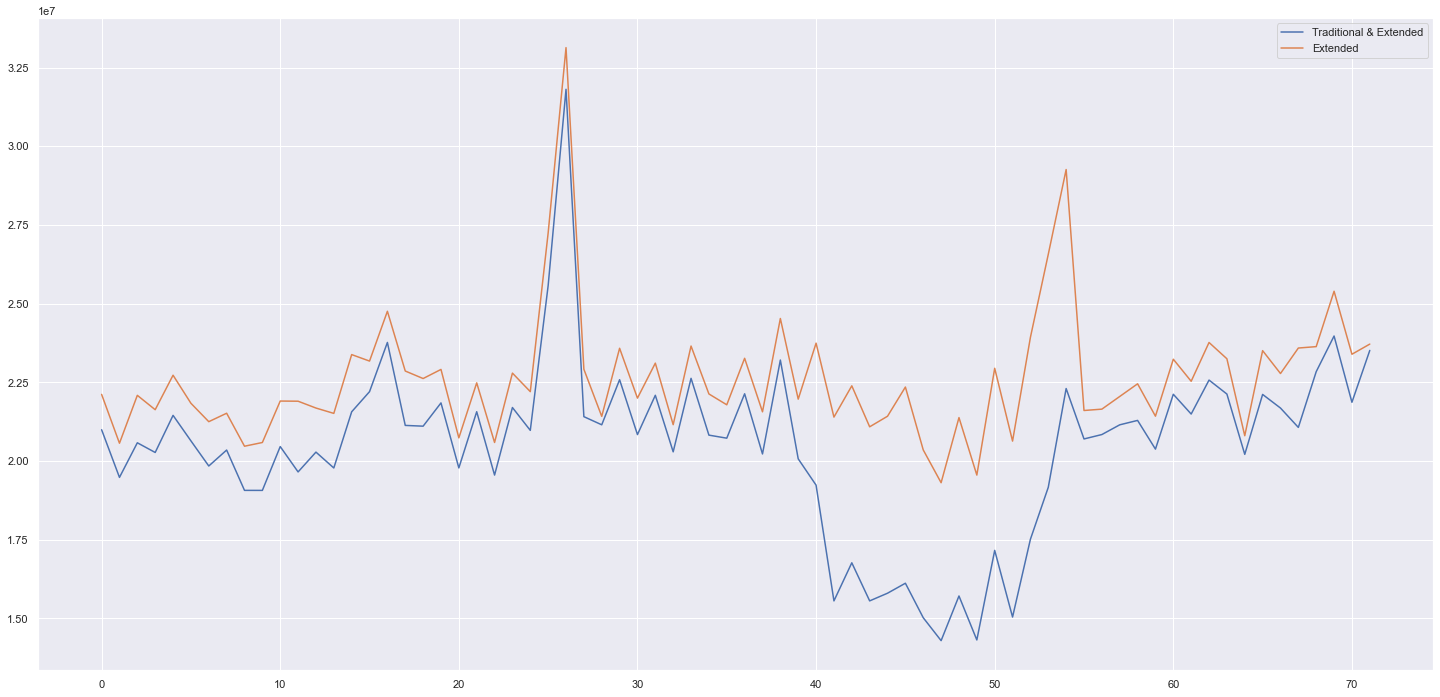

In [23]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax = ax)

ax.legend(labels = ['Traditional & Extended', 'Extended'])

H8 - Stores open during Christmas holiday should sell more

<AxesSubplot:xlabel='year', ylabel='sales'>

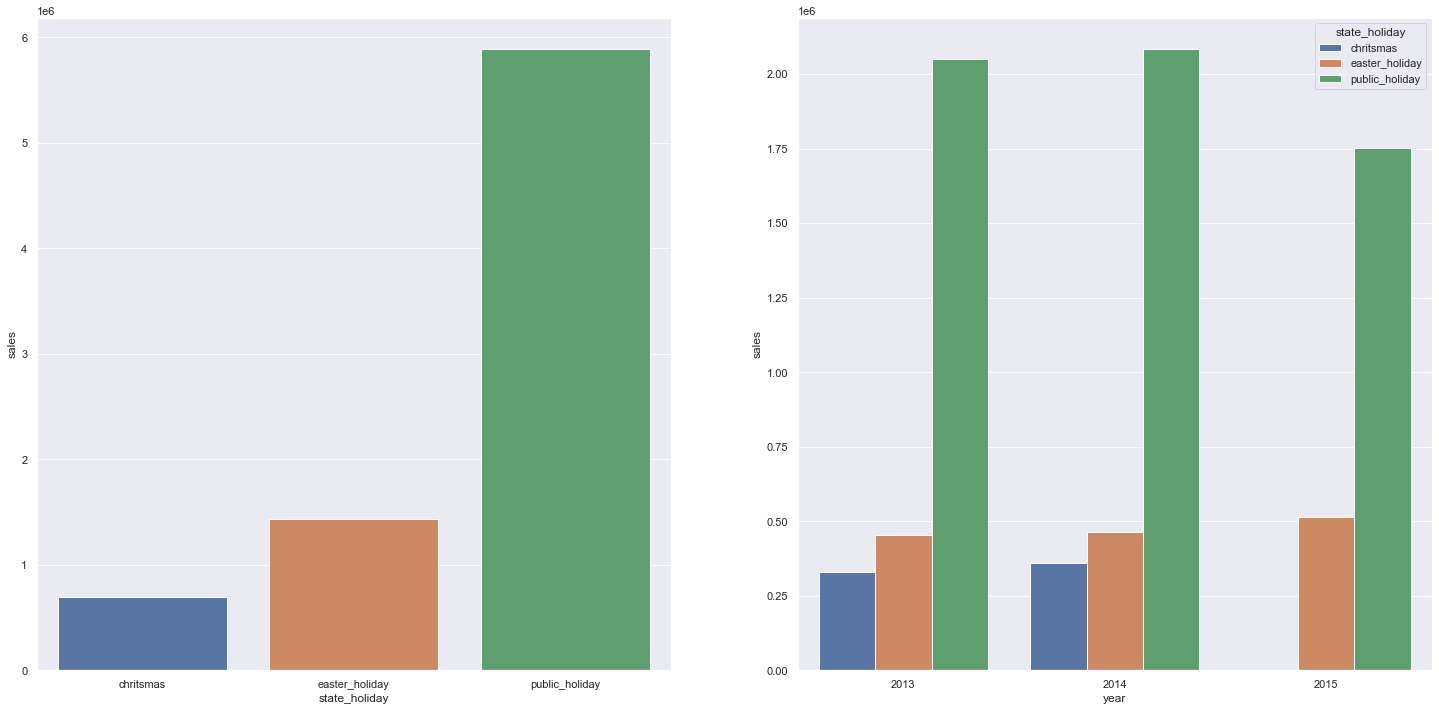

In [24]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot( x = 'year', y = 'sales', hue = 'state_holiday', data = aux2)

H9 Stores throught the years should sell more.

<AxesSubplot:>

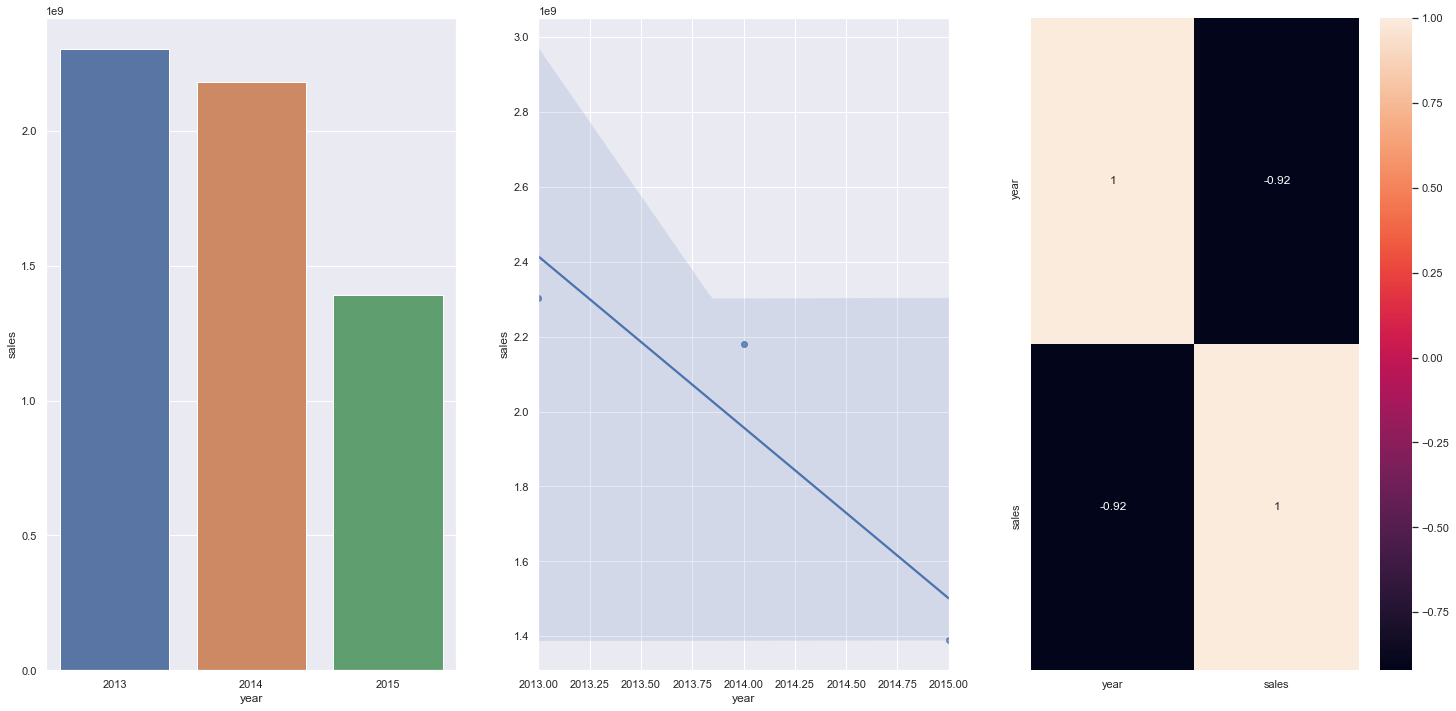

In [25]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x = 'year', y ='sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot( x = 'year', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

H10 Stores sell more at the second semester

<AxesSubplot:>

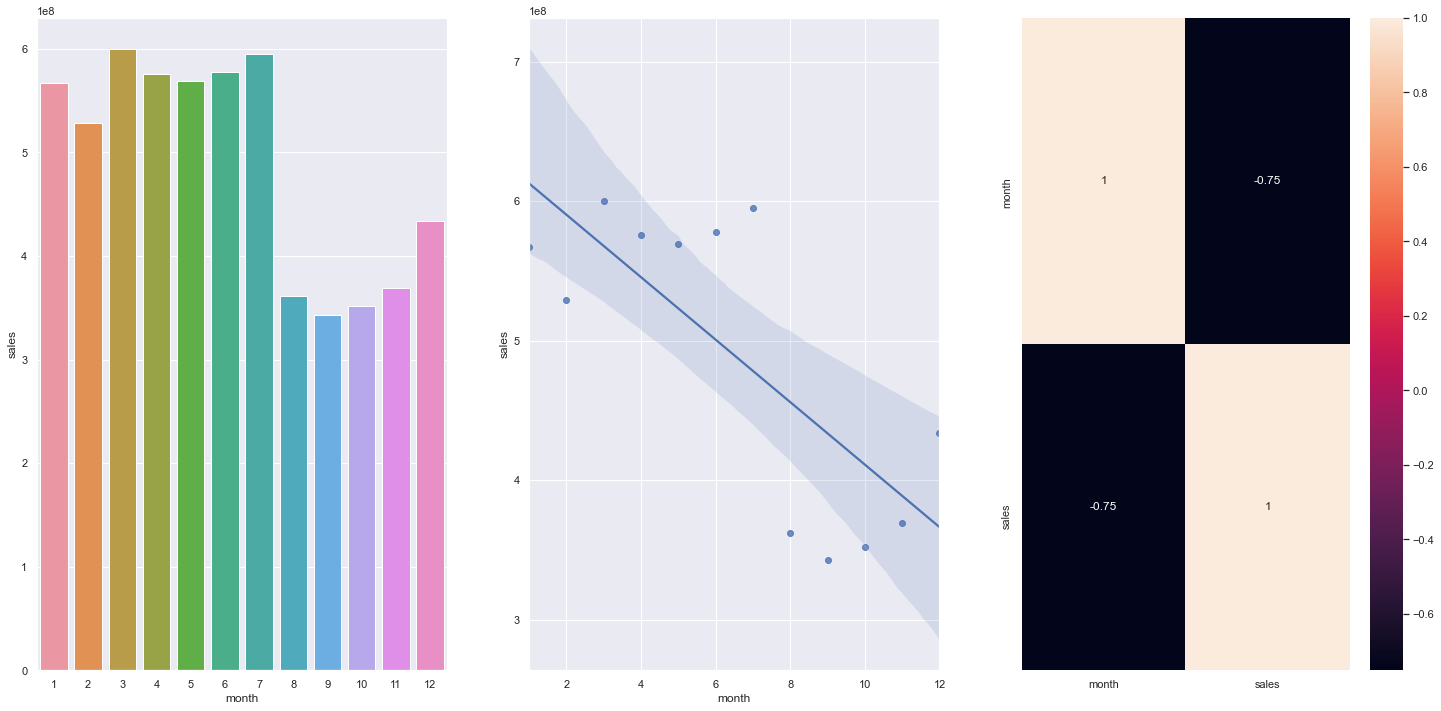

In [26]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

H11 Stores should sell more after the 10th of each month.

<AxesSubplot:xlabel='before_after', ylabel='sales'>

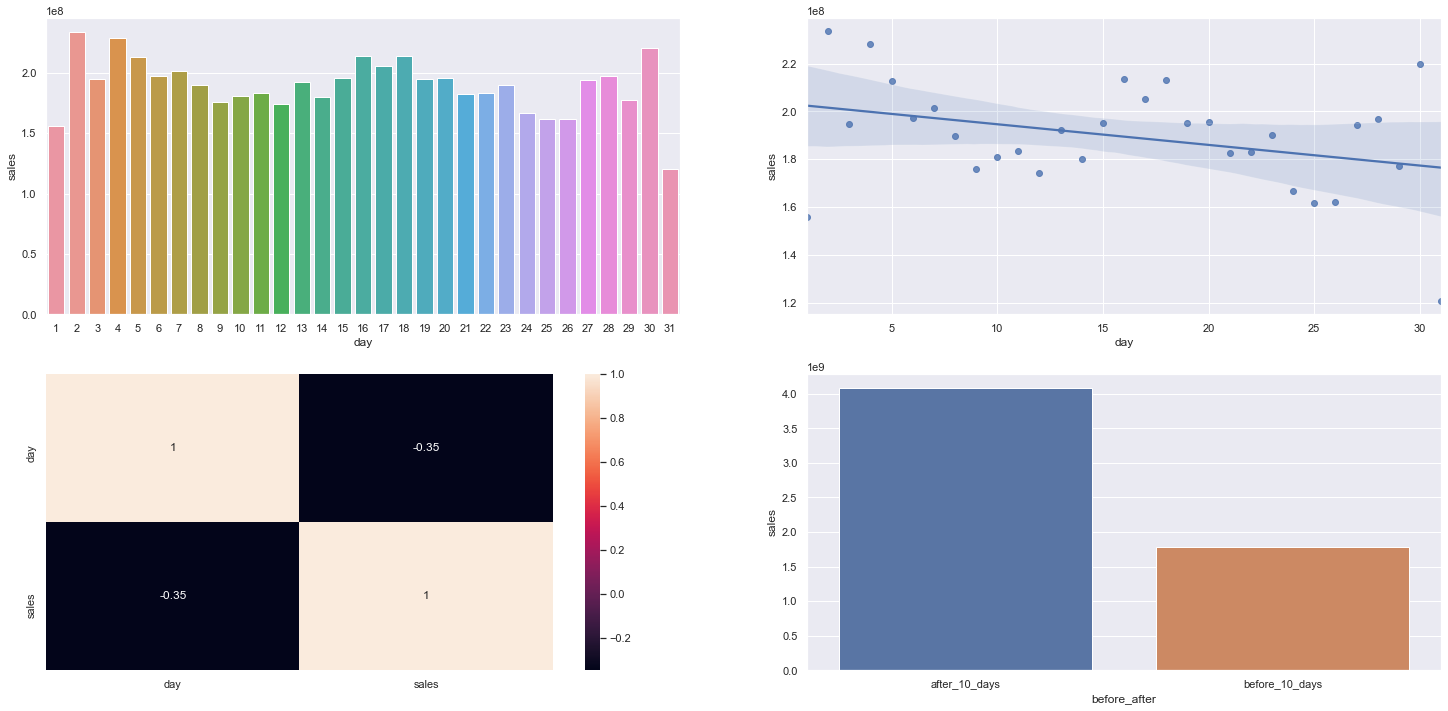

In [27]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2,2,2)
sns.regplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x < 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = 'before_after', y='sales', data=aux2)


H12 - Stores should sell less on weekends

<AxesSubplot:>

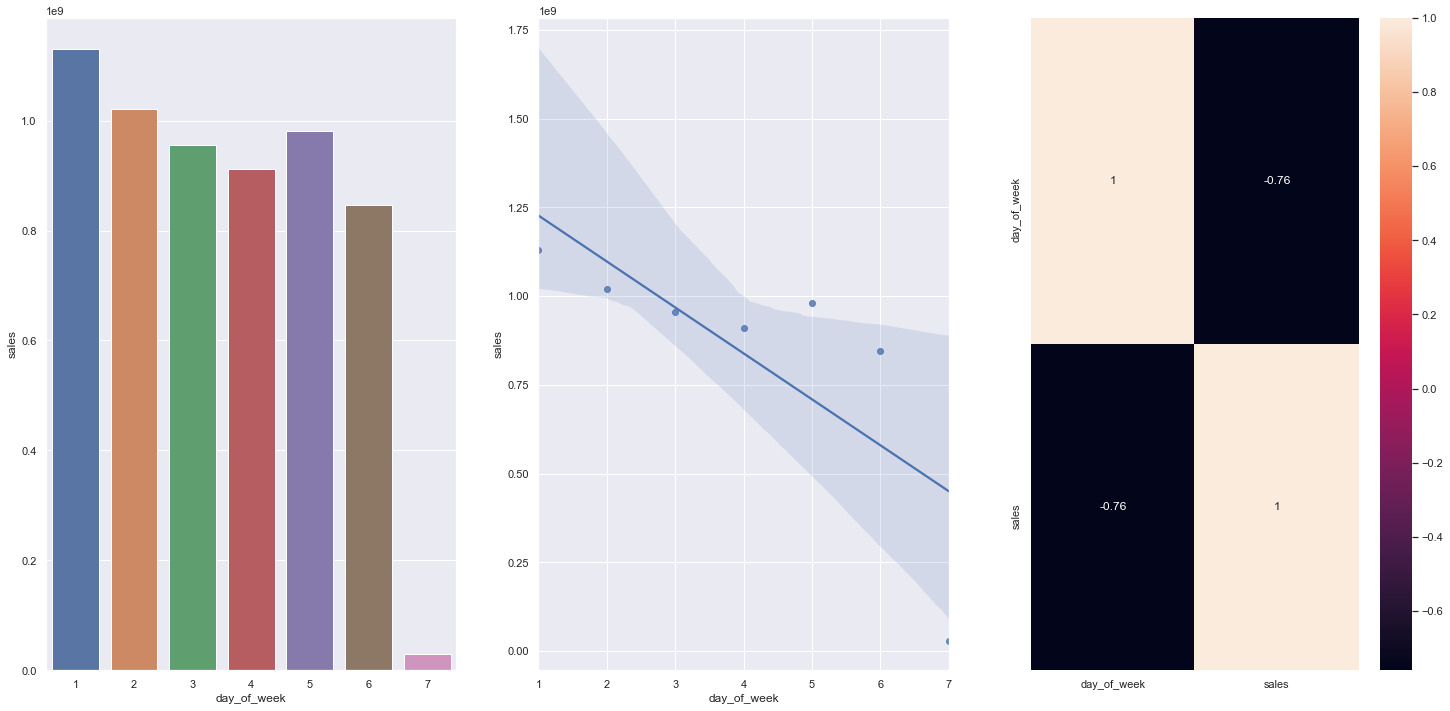

In [28]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot( x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)


H13 Sroe should sell less during school holidays

<AxesSubplot:xlabel='month', ylabel='sales'>

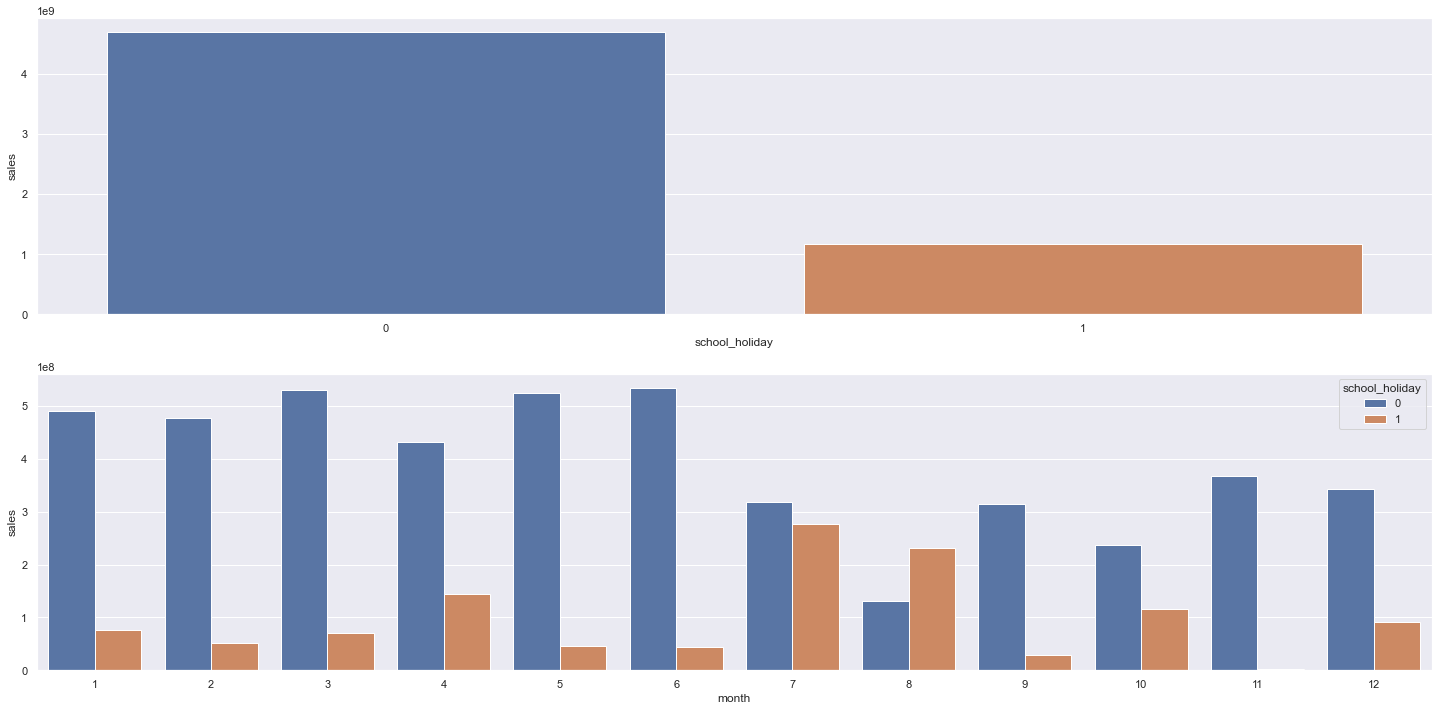

In [29]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot( x = 'month', y ='sales', hue = 'school_holiday', data = aux2)


4.2.1 Summary Hypothesis

In [30]:
from tabulate import tabulate
tab = [['Hypothesis', 'Result', 'Relevance'],
       ['H1', 'resulta', 'low or hi'],
       ['H2', 'resulta', 'low or hi'],
       ['H3', 'resulta', 'low or hi'],
       ['H3', 'resulta', 'low or hi']
      ]
print(tabulate(tab, headers = 'firstrow'))



Hypothesis    Result    Relevance
------------  --------  -----------
H1            resulta   low or hi
H2            resulta   low or hi
H3            resulta   low or hi
H3            resulta   low or hi


## 4.3 Multivariate analysis

4.3.1 - Numerical Attribytes:

<AxesSubplot:>

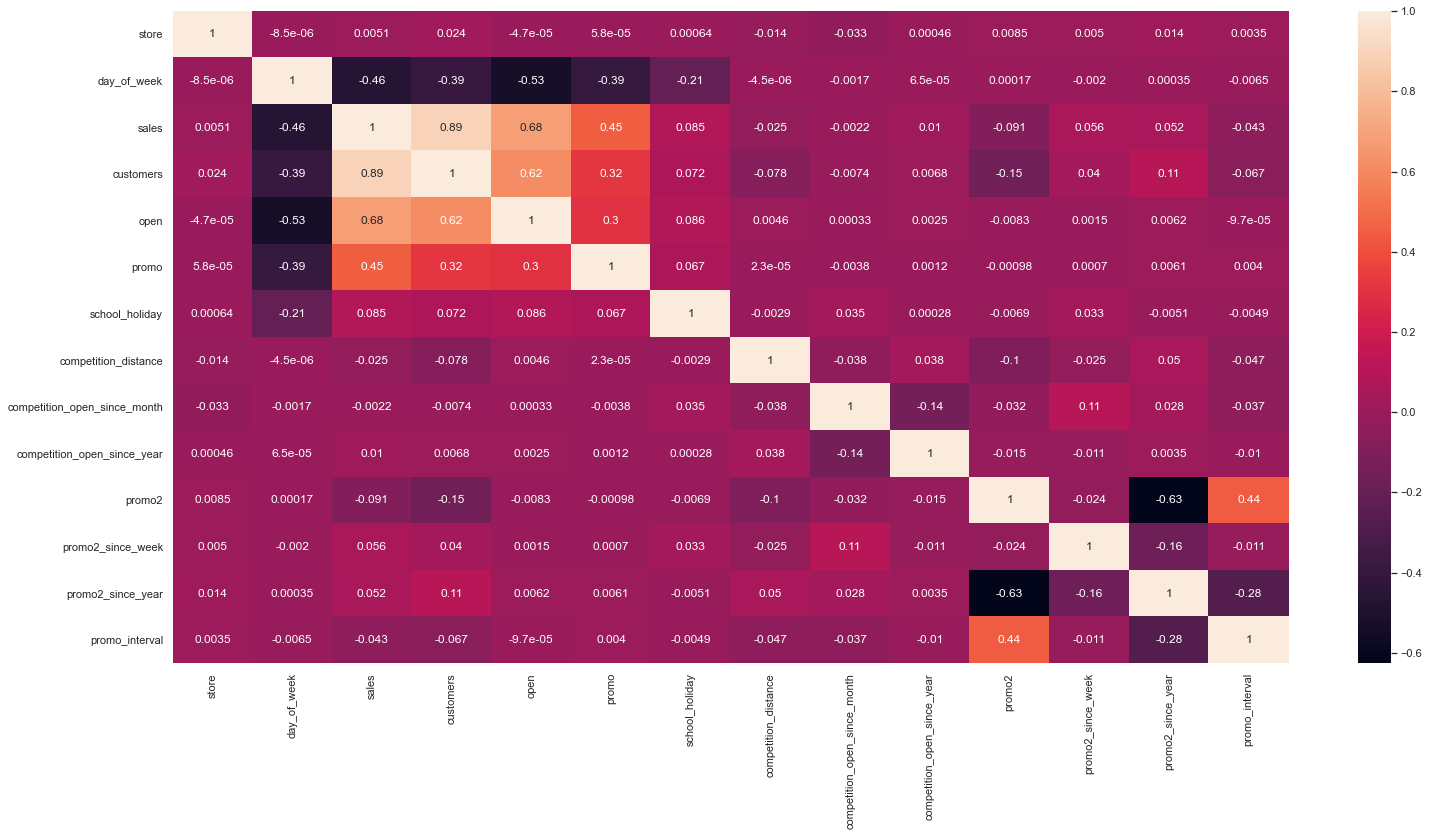

In [31]:
correlation = num_types.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)

4.3.2 - Categorical Attributes - cramer method

<AxesSubplot:>

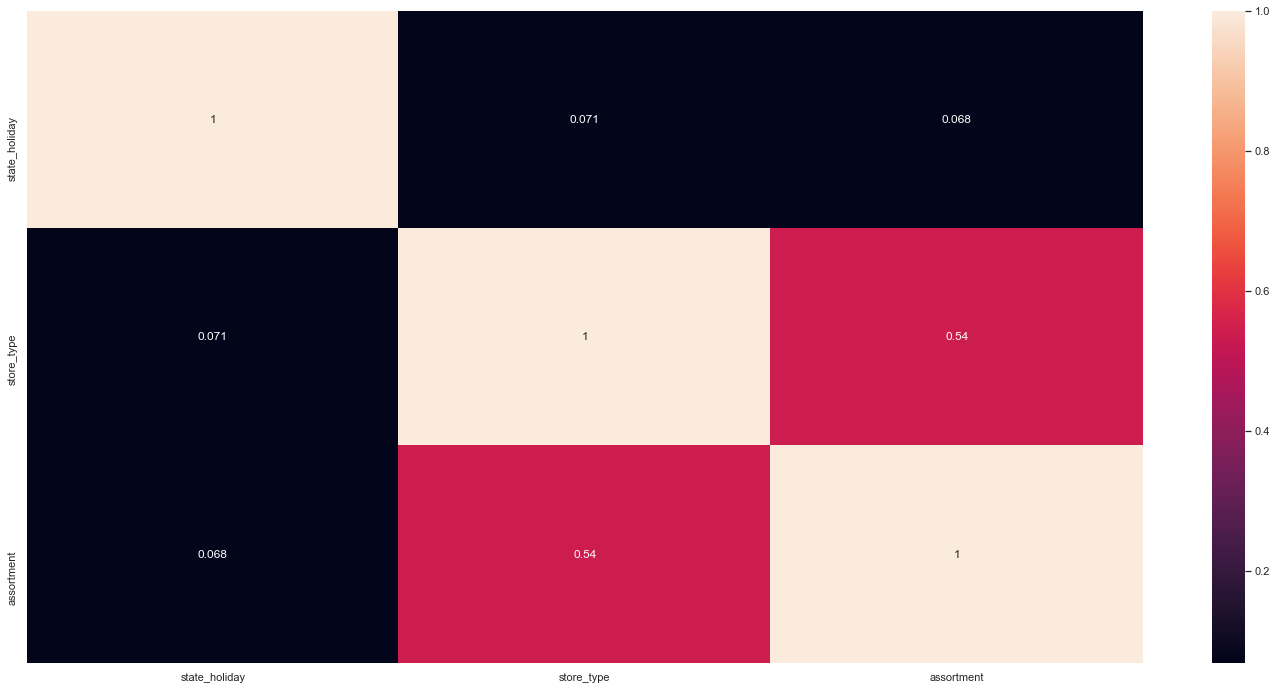

In [32]:
#select categorical data
a = df4.select_dtypes( include = 'object')

# do cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final Dataset:

d = pd.DataFrame( {'state_holiday':[a1,a2,a3],
                  'store_type':[a4,a5,a6],
                  'assortment':[a7,a8,a9] })

d = d.set_index(d.columns)
sns.heatmap(d, annot = True)



In [33]:
df4.to_pickle('04.pkl')

## 5.0 Data Preparation

In [34]:
df5 = df4.copy()

### 5.1 Normalização

In [35]:
# There are no normal distribution by looking at the univariate analysis.

### 5.2 Rescaling

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

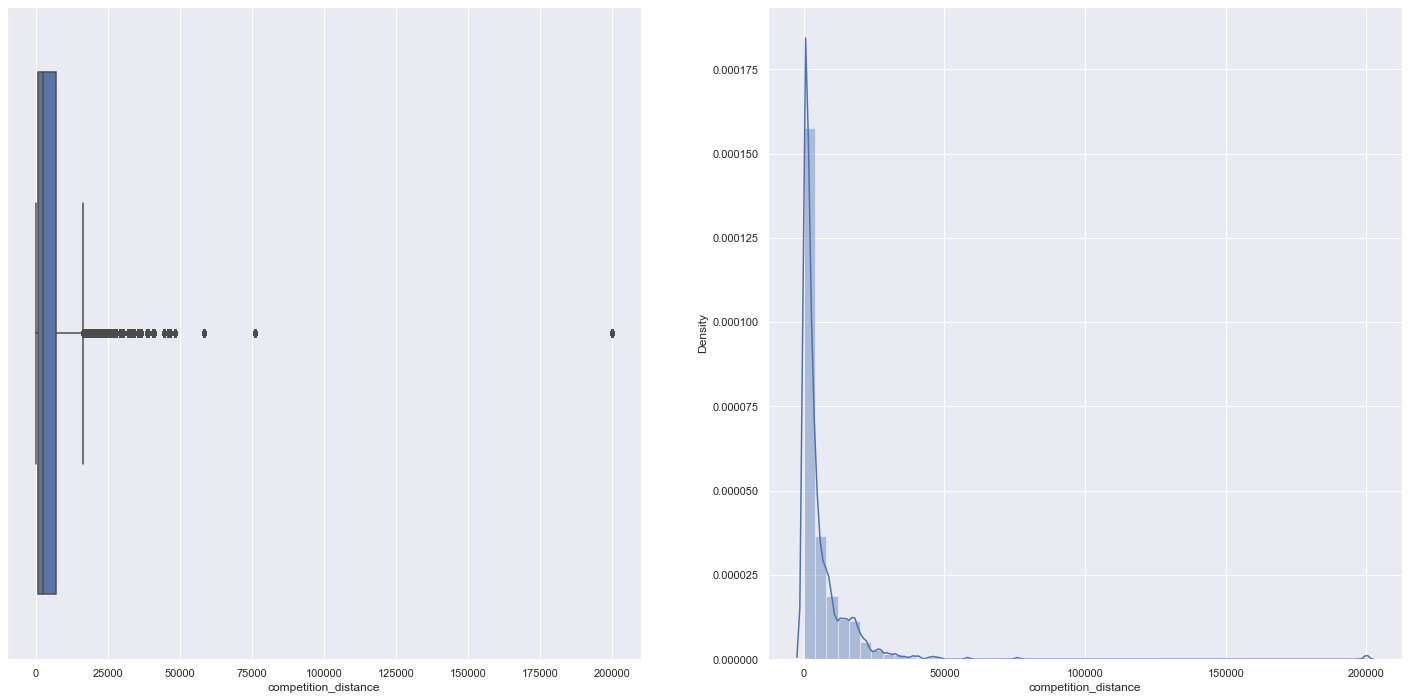

In [36]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
plt.subplot(1,2, 1)
sns.boxplot(df5['competition_distance'])
plt.subplot(1,2, 2)
sns.distplot(df5['competition_distance'])

In [37]:
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

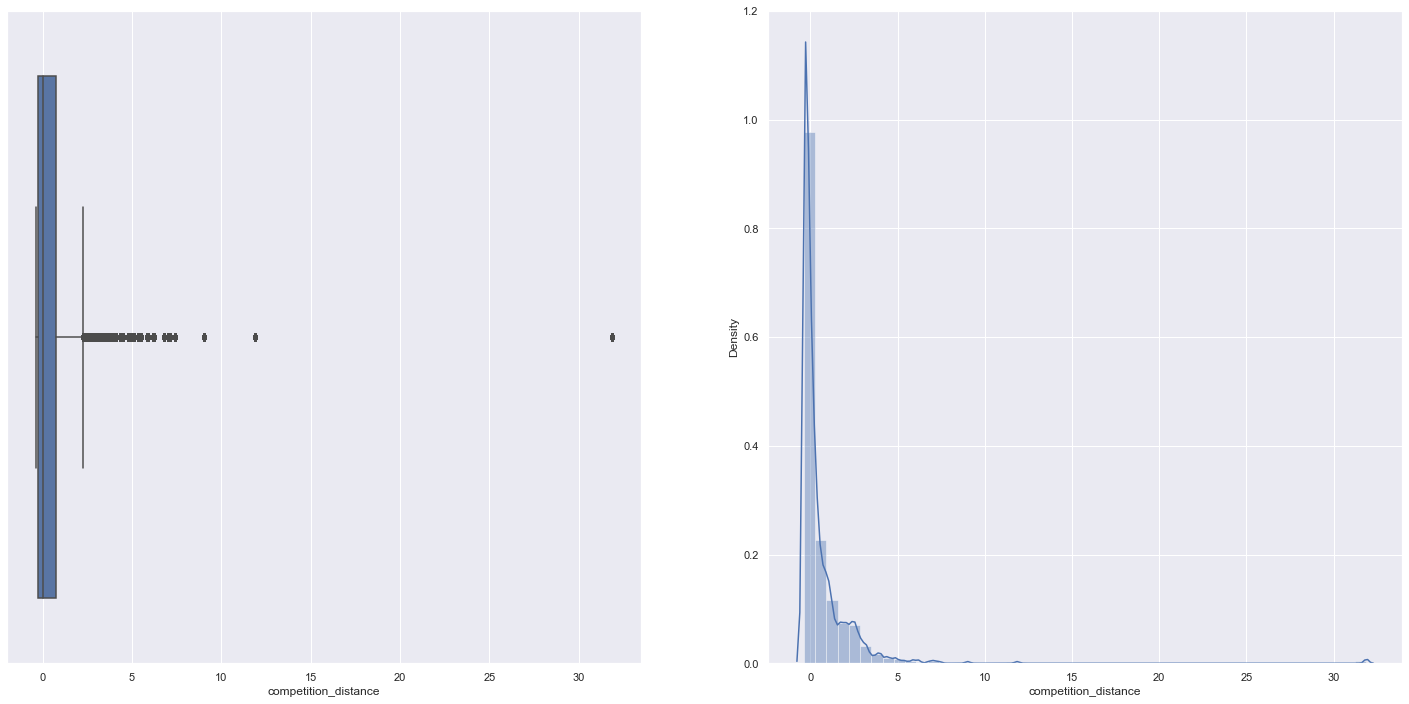

In [38]:
plt.subplot(1,2, 1)
sns.boxplot(df5['competition_distance'])
plt.subplot(1,2, 2)
sns.distplot(df5['competition_distance'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_length_months', ylabel='Density'>

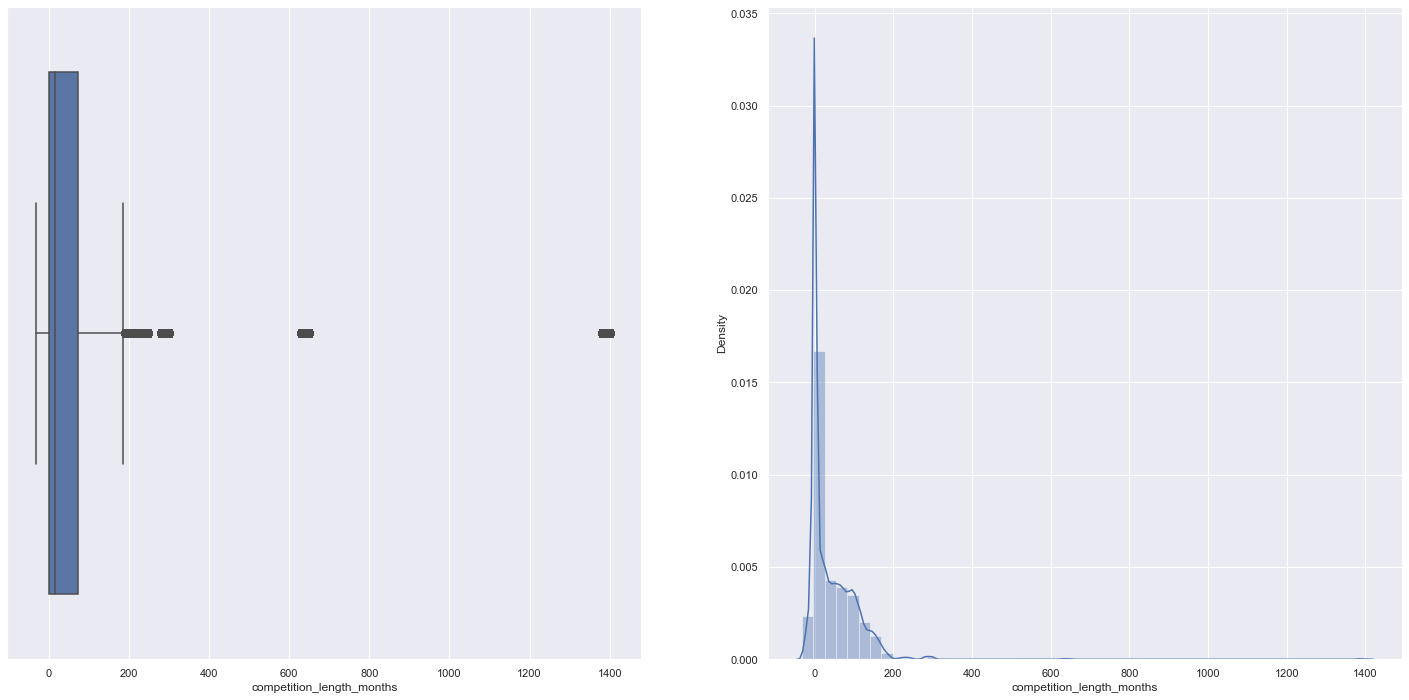

In [39]:
plt.subplot(1,2, 1)
sns.boxplot(df5['competition_length_months'])
plt.subplot(1,2, 2)
sns.distplot(df5['competition_length_months'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_length_months', ylabel='Density'>

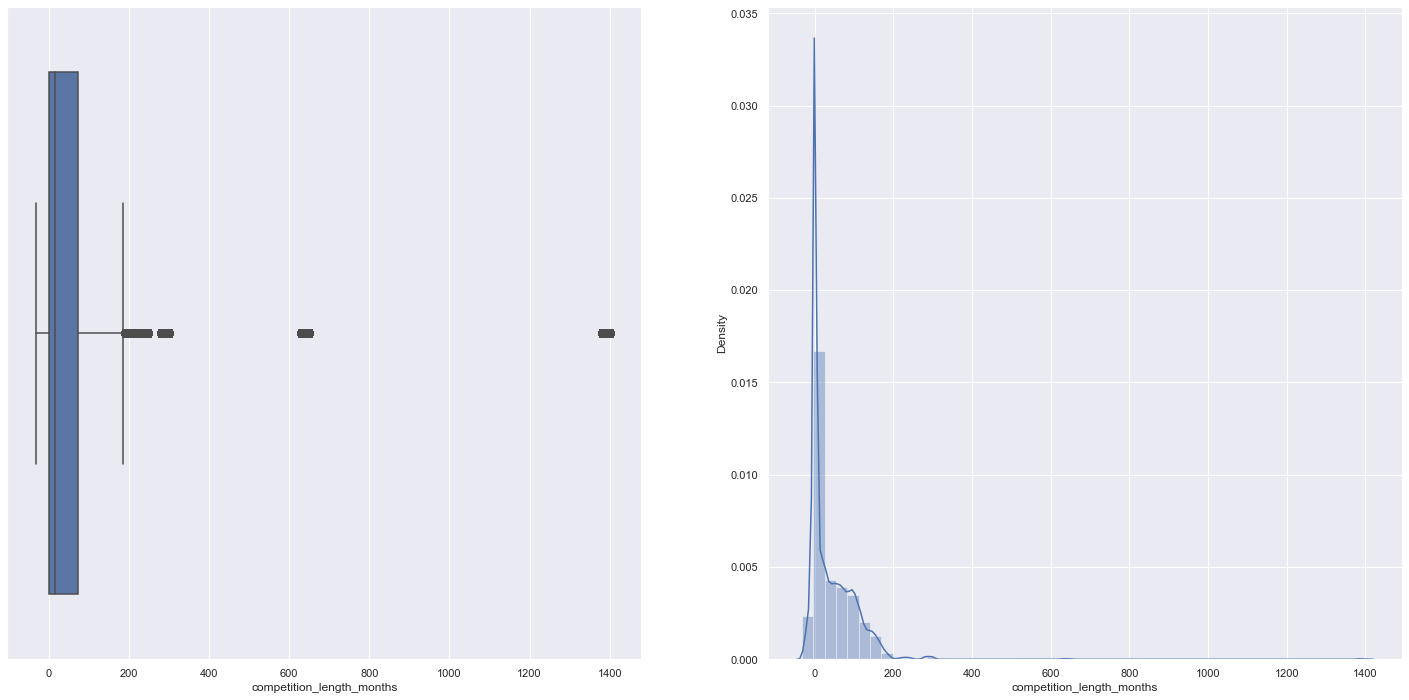

In [40]:
#competition time month

df5['competition_time_month'] = rs.fit_transform(df5[['competition_length_months']])
plt.subplot(1,2, 1)
sns.boxplot(df5['competition_length_months'])
plt.subplot(1,2, 2)
sns.distplot(df5['competition_length_months'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='promo_time_week', ylabel='Density'>

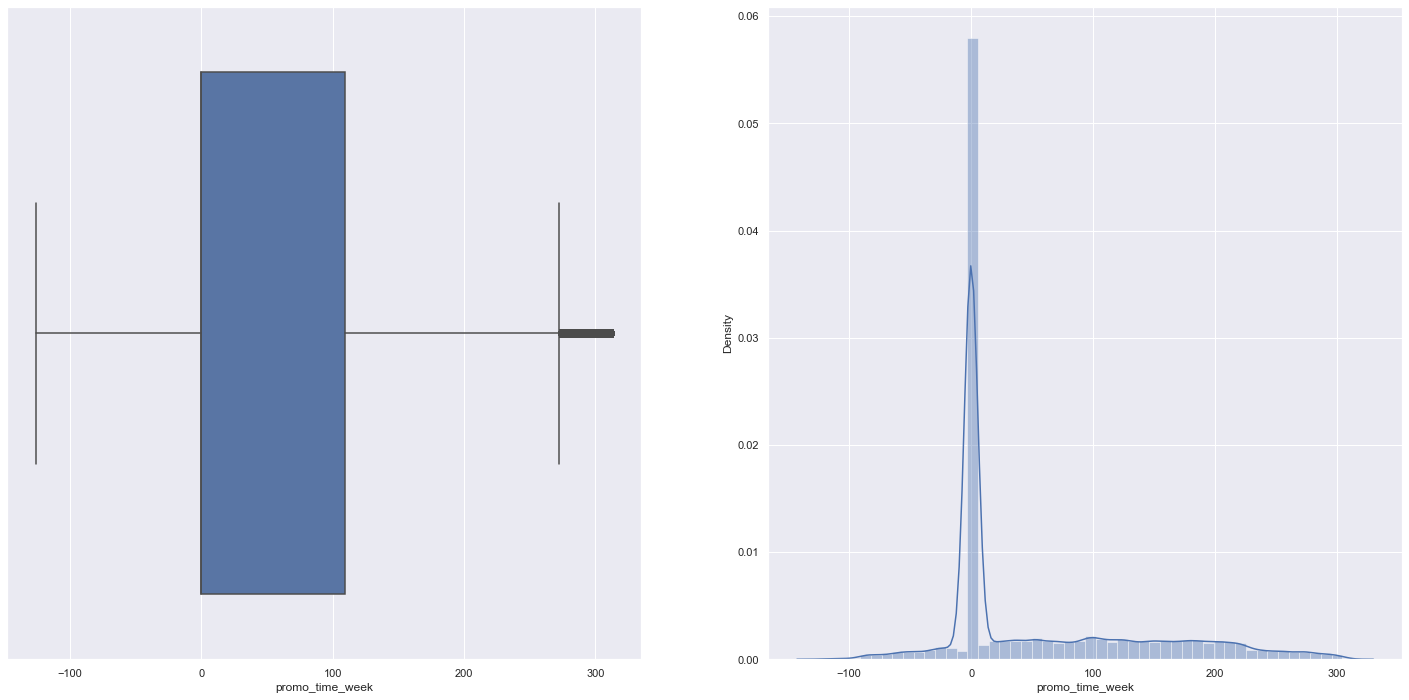

In [41]:
plt.subplot(1,2, 1)
sns.boxplot(df5['promo_time_week'])
plt.subplot(1,2, 2)
sns.distplot(df5['promo_time_week'])

In [42]:
# proomo time week
df5.promo_time_week = mms.fit_transform(df5[['promo_time_week']].values)



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='promo_time_week', ylabel='Density'>

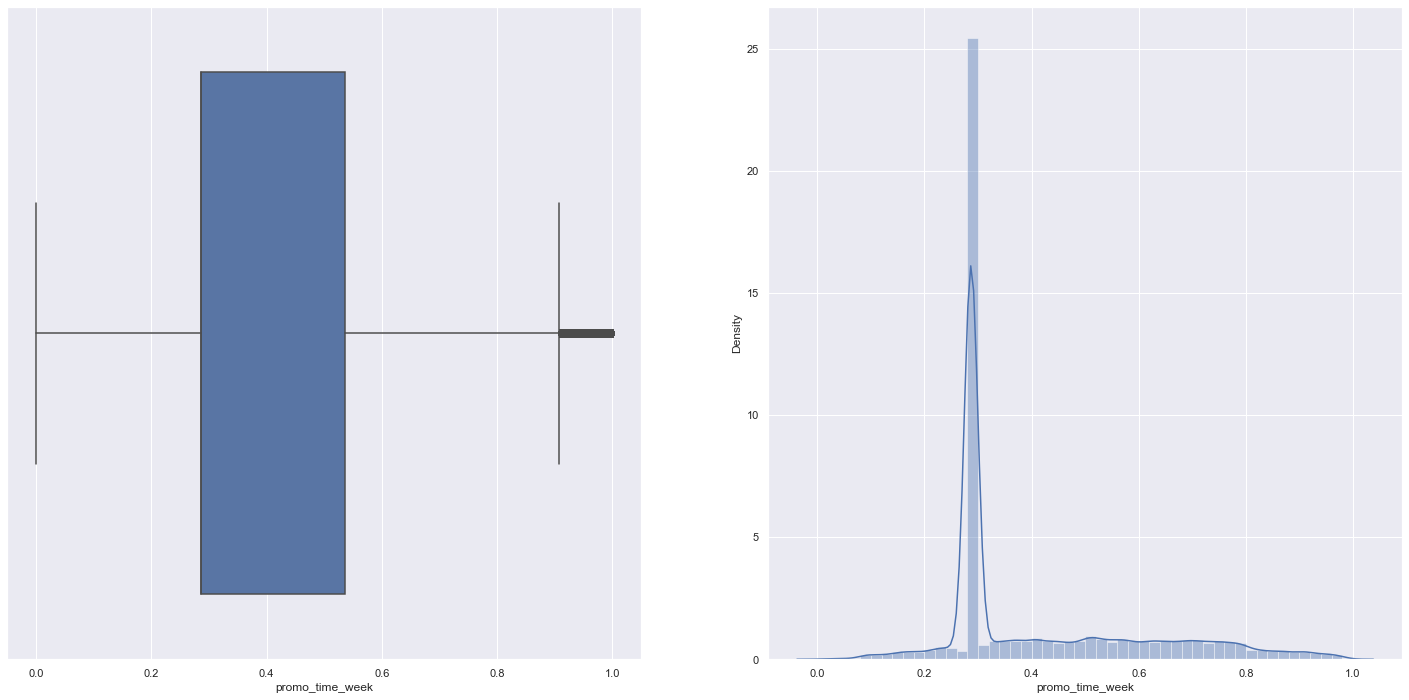

In [43]:
plt.subplot(1,2, 1)
sns.boxplot(df5['promo_time_week'])
plt.subplot(1,2, 2)
sns.distplot(df5['promo_time_week'])

In [44]:
# year

df5['year'] = mms.fit_transform(df5[['year']].values)

### 5.3 - Transformation 

#### 5.3.1 Encoding - Tranform num variable cyclical nature


In [45]:
# state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix =['state_holiday'], columns =['state_holiday'])

In [46]:
df5.head(3)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,year,month,day,week_of_year,year_week,competition_since,competition_length_months,promo_since,promo_time_week,competition_time_month,state_holiday_chritsmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,2008,0,31,2015,1.0,7,31,31,2015-30,2008-09-01,84,2015-07-27,0.287016,0.918919,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,2007,1,13,2010,1.0,7,31,31,2015-30,2007-11-01,94,2010-03-22,0.922551,1.054054,0,0,0,1
2,3,5,2015-07-31,8314,1,1,a,basic,1.903226,12,2006,1,14,2011,1.0,7,31,31,2015-30,2006-12-01,105,2011-03-28,0.801822,1.202703,0,0,0,1


In [47]:
# Store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])


In [48]:
df5.head(3)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,year,month,day,week_of_year,year_week,competition_since,competition_length_months,promo_since,promo_time_week,competition_time_month,state_holiday_chritsmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,basic,-0.170968,9,2008,0,31,2015,1.0,7,31,31,2015-30,2008-09-01,84,2015-07-27,0.287016,0.918919,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,basic,-0.283871,11,2007,1,13,2010,1.0,7,31,31,2015-30,2007-11-01,94,2010-03-22,0.922551,1.054054,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,basic,1.903226,12,2006,1,14,2011,1.0,7,31,31,2015-30,2006-12-01,105,2011-03-28,0.801822,1.202703,0,0,0,1


In [49]:
#assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [50]:
df5.head(3)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,year,month,day,week_of_year,year_week,competition_since,competition_length_months,promo_since,promo_time_week,competition_time_month,state_holiday_chritsmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,1.0,7,31,31,2015-30,2008-09-01,84,2015-07-27,0.287016,0.918919,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1.0,7,31,31,2015-30,2007-11-01,94,2010-03-22,0.922551,1.054054,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1.0,7,31,31,2015-30,2006-12-01,105,2011-03-28,0.801822,1.202703,0,0,0,1


#### 5.3.2 - Response Variable Transformation

In [51]:
df5['sales'] = np.log1p(df5['sales'])

In [52]:
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                  float64
promo                                    int64
school_holiday                           int64
store_type                               int32
assortment                               int64
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
year                                   float64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_since               datetime64[ns]
competition_length_months                int32
promo_since  

#### 5.3.3 - Nature Transformation

In [53]:
# day of the week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2. * np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. * np.pi/12)))

# day
df5['day_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. * np.pi/30)))
df5['day_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. * np.pi/30)))

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2. * np.pi/52)))






In [54]:
df5.to_pickle('05.pkl')

# 6.0 Feature Selection

In [55]:
df6 = df5.copy()

## 6.1 - Split dataframe into training and test dataset

In [56]:
# training dataset
cols_drop = ['week_of_year', 'day', 'month', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)


In [57]:
# test dataset
# 6 weeks...
# till where dataset goes...
# the need to take out some information in order to check the model accuracy
# otherwise 'model already knows that information' - so it will know 'the future'

df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 7 * 6) # (7 dias vezes 6 semanas)




Timestamp('2015-06-19 00:00:00')

In [58]:
# this is the training dataset:
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset:
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


print('Trainint Min Date: {}'.format(X_train['date'].min()))
print('Trainint Max Date: {}'.format(X_train['date'].max()))
print('\n Test Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))



Trainint Min Date: 2013-01-01 00:00:00
Trainint Max Date: 2015-06-18 00:00:00

 Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as feature selector

In [59]:
# Training and test datasets for Borura

X_train.head()
X_train_n = X_train.drop(['date','sales'], axis =1).values #get only values, to get a numpy
y_train_n = y_train.values.ravel()  # ravel puts everything inside a vector




#### BORUTA RUN - ( +5h running time!!)

In [60]:
#define Random Forest Regressor
####rf = RandomForestRegressor( n_jobs = -1 ) #parametro pra usar todos os cores da maquina


#rf = randon forest
#boruta nao aceita df, tem que ser um numpy vect(?)or
#####boruta = BorutaPy(rf, n_estimators = 'auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n)

In [61]:
###cols_selected = boruta.support_.tolist()

# getting borutas best list selected:
###X_train_fs = X_train.drop( ['date', 'sales'], axis = 1)
###cols_selected_boruta = X_train_fs1.iloc[:, cols_selected].columns.to_list()

# borutas not selected  columns:
###cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [62]:
cols_selected_boruta = ['store','promo','store_type','assortment','competition_distance', 'competition_open_since_month','competition_open_since_year','promo2','promo2_since_week','promo2_since_year', 'competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos','month_cos','day_sin', 'day_cos','week_of_year_cos',]

In [63]:
cols_selected_boruta # with extras hand-picked

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [64]:
feat_to_add = ['date','sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [65]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'date',
 'sales']

# 7.0 - Machine Learning Modeling

In [66]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]


In [67]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

def ml_error(model_name, y, yhat): # alternative formula for comparison with library one -   mean absolute error
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    #
    return(pd.DataFrame({'ModelName': model_name,
                        'MAE': mae,
                        'MAPE':mape,
                        'RMSE': rmse}, index=[0]))

### 7.1 - Average Model

In [68]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns ={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance:
baseline_result = ml_error('Average Model', np.expm1( y_test), np.expm1(yhat_baseline))
print(mean_absolute_error(np.expm1(y_test), np.expm1(yhat_baseline)))
print(mean_absolute_percentage_error(np.expm1(y_test), np.expm1(yhat_baseline)))
print(baseline_result)


1354.8003525745385
0.20640038121581475
       ModelName          MAE    MAPE         RMSE
0  Average Model  1354.800353  0.2064  1835.135542


## 7.2 - Linear Regression Model

In [69]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result_f = mean_absolute_error(np.expm1(y_test), np.expm1(yhat_lr))
print(lr_result_f)
print(lr_result)

1881.0671348182354
           ModelName          MAE      MAPE         RMSE
0  Linear Regression  1881.067135  0.302175  2663.329435


### 7.2.1 - Linear Regression- Cross Validation

In [70]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2045.62 +/- 241.18,0.3 +/- 0.01,2912.05 +/- 353.82


## 7.3 Linear Regression Regularized Model - Lasso

In [71]:
#model
lrr = Lasso( alpha = 0.01).fit(x_train, y_train)
#prediction
yhat_lrr = lrr.predict(x_test)
#performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result

,ModelName,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1894.72603,0.29002,2747.905817


### 7.3.1 Cross Validation - Lasso

In [72]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose = True)
lrr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2119.34 +/- 339.78,0.29 +/- 0.01,3061.66 +/- 502.28


## 7.4 Random Forest Regressor

In [73]:
# #model
# rf = RandomForestRegressor( n_estimators = 100, n_jobs =-1, random_state=42).fit(x_train, y_train)

# #prediction
# yhat_rf = rf.predict(x_test)

# #performance
# rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
# rf_result

In [76]:
# import pickle
# with open("rf.file", "wb") as file:
#     pickle.dump(rf, file, pickle.HIGHEST_PROTOCOL)
# with open("yhat_rf.file", "wb") as file:
#     pickle.dump(yhat_rf, file, pickle.HIGHEST_PROTOCOL)
# with open("rf_result.file", "wb") as file:
#     pickle.dump(rf_result, file, pickle.HIGHEST_PROTOCOL)


with open("rf.file", "rb") as file:
    rf = pickle.load(file)
with open("yhat_rf.file", "rb") as file:
    yhat_rf = pickle.load(file)
with open("rf_result.file", "rb") as file:
    rf_result = pickle.load(file)
  

### 7.4.1 - Random Forest Cross Validation

In [77]:
# rf_result_cv = cross_validation(x_training, 5,'Random Forest', rf, verbose = True)
# rf_result_cv

#rf_result_cv.to_pickle('./rf_result_cv.pkl')
rf_result_cv = pd.read_pickle('./rf_result_cv.pkl')

## 7.5 - XGBoost Regressor

In [78]:
import xgboost as xgb

In [79]:
#model
# model_xgb = xgb.XGBRegressor( objective ='reg:squarederror',   # 952.028575 -> too few, of diff
#                              n_estimators = 300, # 100
#                              eta=0.10, # 0.01 # (mudando eta .01 original, worse)
#                              max_depth=12, # 10
#                              subsample=0.7,
#                              colsample_bytree=0.9).fit(x_train, y_train)


#### current model : ######################################################

# model_xgb = xgb.XGBRegressor( objective ='reg:squarederror',   # 967.028584
#                              n_estimators = 240, # 100
#                              eta=0.08, # 0.01 # (mudando eta .01 original, worse)
#                              max_depth=12, # 10
#                              subsample=0.7,
#                              colsample_bytree=0.9).fit(x_train, y_train)

###########################################################################

# model_xgb = xgb.XGBRegressor( objective ='reg:squarederror',  # 1.065
#                              n_estimators = 200, # 100
#                              eta=0.06, # 0.01 # (mudando eta .01 original, worse)
#                              max_depth=12, # 10
#                              subsample=0.7,
#                              colsample_bytree=0.9).fit(x_train, y_train)
# model_xgb = xgb.XGBRegressor( objective ='reg:squarederror',   # RMSE 2.183
#                              n_estimators = 200, # 100
#                              eta=0.02, # 0.01
#                              max_depth=12, # 10
#                              subsample=0.7,
#                              colsample_bytree=0.9).fit(x_train, y_train)
# model_xgb = xgb.XGBRegressor( objective ='reg:squarederror',   # RMSE 1.229
#                              n_estimators = 200, # 100
#                              eta=0.04, # 0.01 # (mudando eta .01 original, worse)
#                              max_depth=12, # 10
#                              subsample=0.7,
#                              colsample_bytree=0.9).fit(x_train, y_train)



#prediction
# yhat_xgb = model_xgb.predict(x_test)

# #performance
# xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
# xgb_result

In [80]:
# import pickle
# with open("model_xgb.file", "wb") as file:
#     pickle.dump(model_xgb, file, pickle.HIGHEST_PROTOCOL)


with open("model_xgb.file", "rb") as file:
    model_xgb = pickle.load(file)
yhat_xgb = model_xgb.predict(x_test)
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))


### XG Boost Cross Validation

In [81]:
# xg_boost_cv = cross_validation(x_training, 5, 'XGBoost', model_xgb, verbose = True )
# xg_boost_cv

# xgb_result_cv = xg_boost_cv.copy()
# xgb_result_cv.to_pickle('./xg_result_cv')
xgb_result_cv = pd.read_pickle('./xg_result_cv')
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,878.0 +/- 244.43,0.12 +/- 0.03,1308.8 +/- 415.1


## 7.6 - Compare Model´s Performance

### 7.6.1 - Single Performance

In [82]:
modelling_results = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_results.sort_values( 'RMSE')

# for a in [baseline_result, lr_result, lrr_result, xgb_result]:
#     print(a)

,ModelName,MAE,MAPE,RMSE
0,XGBoost Regressor,652.534595,0.094306,967.028584
0,Random Forest Regressor,649.987200,0.095682,969.175573
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1881.067135,0.302175,2663.329435
0,Linear Regression - Lasso,1894.726030,0.290020,2747.905817


### 7.6.2 - Real Performance


In [83]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2045.62 +/- 241.18,0.3 +/- 0.01,2912.05 +/- 353.82
0,Lasso,2119.34 +/- 339.78,0.29 +/- 0.01,3061.66 +/- 502.28
0,Random Forest,897.54 +/- 267.21,0.13 +/- 0.03,1354.13 +/- 433.29
0,XGBoost,878.0 +/- 244.43,0.12 +/- 0.03,1308.8 +/- 415.1


## 8.2 Hyperparameter fine tuning

### 8.1 Random Search

In [84]:
param = {
    'n_estimators':[15,17,25,30,35], # [1500,1700,2500,3000,3500]
    'eta':[0.01,0.03],
    'max_depth': [3,5,9],
    'subsample': [0.1,0.5,0.7],
    'colsample_bytree': [0.3,0.7,0.9],
    'min_child_weight': [3,5,15]
}
MAX_EVAL =5  # do  10.

In [89]:
import random

# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     #choosing values for parameters randomly
#     hp = {k: random.sample(v,1)[0] for k, v in param.items()}
#     print(hp)
    
#     #modeling
#     model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
#                                 n_estimators = hp['n_estimators'],
#                                 eta = hp['eta'],
#                                 max_depth=hp['max_depth'],
#                                 subsample=hp['subsample'],
#                                 colsample_bytree = hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight'])
#     # performance
#     result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True)
#     final_result = pd.concat([final_result, result])


# final_result.to_pickle('final_result.file')

# with open('final_result.file','wb') as file:
#     pickle.dump(final_result, file, pickle.HIGHEST_PROTOCOL)
# final_result

with open('final_result','rb') as file:  #TODO change filename!
    final_result = pd.read_pickle('./final_result')
    
final_result    

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7351.36 +/- 598.85,1.0 +/- 0.0,8004.77 +/- 698.44
0,XGBoost Regressor,7346.39 +/- 598.75,1.0 +/- 0.0,8000.13 +/- 698.36
0,XGBoost Regressor,7355.17 +/- 598.86,1.0 +/- 0.0,8008.22 +/- 698.43
0,XGBoost Regressor,7331.34 +/- 598.53,0.99 +/- 0.0,7986.0 +/- 698.18
0,XGBoost Regressor,7355.17 +/- 598.88,1.0 +/- 0.0,8008.2 +/- 698.44


In [90]:
final_result


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7351.36 +/- 598.85,1.0 +/- 0.0,8004.77 +/- 698.44
0,XGBoost Regressor,7346.39 +/- 598.75,1.0 +/- 0.0,8000.13 +/- 698.36
0,XGBoost Regressor,7355.17 +/- 598.86,1.0 +/- 0.0,8008.22 +/- 698.43
0,XGBoost Regressor,7331.34 +/- 598.53,0.99 +/- 0.0,7986.0 +/- 698.18
0,XGBoost Regressor,7355.17 +/- 598.88,1.0 +/- 0.0,8008.2 +/- 698.44


### 8.2 Final Model

In [93]:
# param_tuned = {
#     'n_estimators': 3,  # 3000
#     'eta': 0.03,  # .03
#     'max_depth': 5,  # 5
#     'subsample': 0.7,  #.07
#     'colsample_bytree': 0.7,  #.07
#     'min_child_weight': 3  #3
# }


param_tuned = {'n_estimators' : 240, 'eta' : 0.08, 'max_depth':12, 
               'subsample':0.7, 'colsample_bytree':0.9,'min_child_weight': 3}






In [94]:
# modeling
# model_xgb_tuned = xgb.XGBRegressor(objective ='reg:squarederror',
#                                   n_estimators = param_tuned['n_estimators'],
#                                   eta = param_tuned['eta'],
#                                   max_depth = param_tuned['max_depth'],
#                                   subsample = param_tuned['subsample'],
#                                   colsample_bytree = param_tuned['colsample_bytree'],
#                                   min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

# #prediction
# yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# #performance
# xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))

###################################################
import pickle
# with open("model_xgb_tuned.file", "wb") as file:
#     pickle.dump(model_xgb_tuned, file, pickle.HIGHEST_PROTOCOL)
# with open("yhat_xgb_tuned.file", "wb") as file:
#     pickle.dump(yhat_xgb_tuned, file, pickle.HIGHEST_PROTOCOL)
# with open("xgb_result_tuned.file", "wb") as file:
#     pickle.dump(xgb_result_tuned, file, pickle.HIGHEST_PROTOCOL)


with open("model_xgb_tuned.file", "rb") as file:
    model_xgb_tuned = pickle.load(file)
    
with open("yhat_xgb_tuned.file", "rb") as file:
    yhat_xgb_tuned = pickle.load(file)

with open("xgb_result_tuned.file", "rb") as file:
    xgb_result_tuned = pickle.load(file)







xgb_result_tuned

,ModelName,MAE,MAPE,RMSE
0,XGBoost Regressor,651.701001,0.093499,968.266862


In [95]:
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.001274141169911881

## 9 Tradução e Interpretação do erro

In [96]:
df9 = X_test[ cols_selected_boruta_full ]

# # rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)



<ipython-input-96-3e13496b555f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
<ipython-input-96-3e13496b555f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned)


In [97]:
# Preditction sum
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE

df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store', 'predictions','worst_scenario','best_scenario','MAE','MAPE']]


In [98]:
df92.sort_values('MAPE', ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107118.226562,103760.076480,110476.376645,3358.150082,0.562983
908,909,244608.546875,237440.715523,251776.378227,7167.831352,0.482227
549,550,261798.046875,259921.153518,263674.940232,1876.893357,0.361232
875,876,202371.500000,198314.255615,206428.744385,4057.244385,0.304964
781,782,213034.265625,212240.880015,213827.651235,793.385610,0.230005


<AxesSubplot:xlabel='store', ylabel='MAPE'>

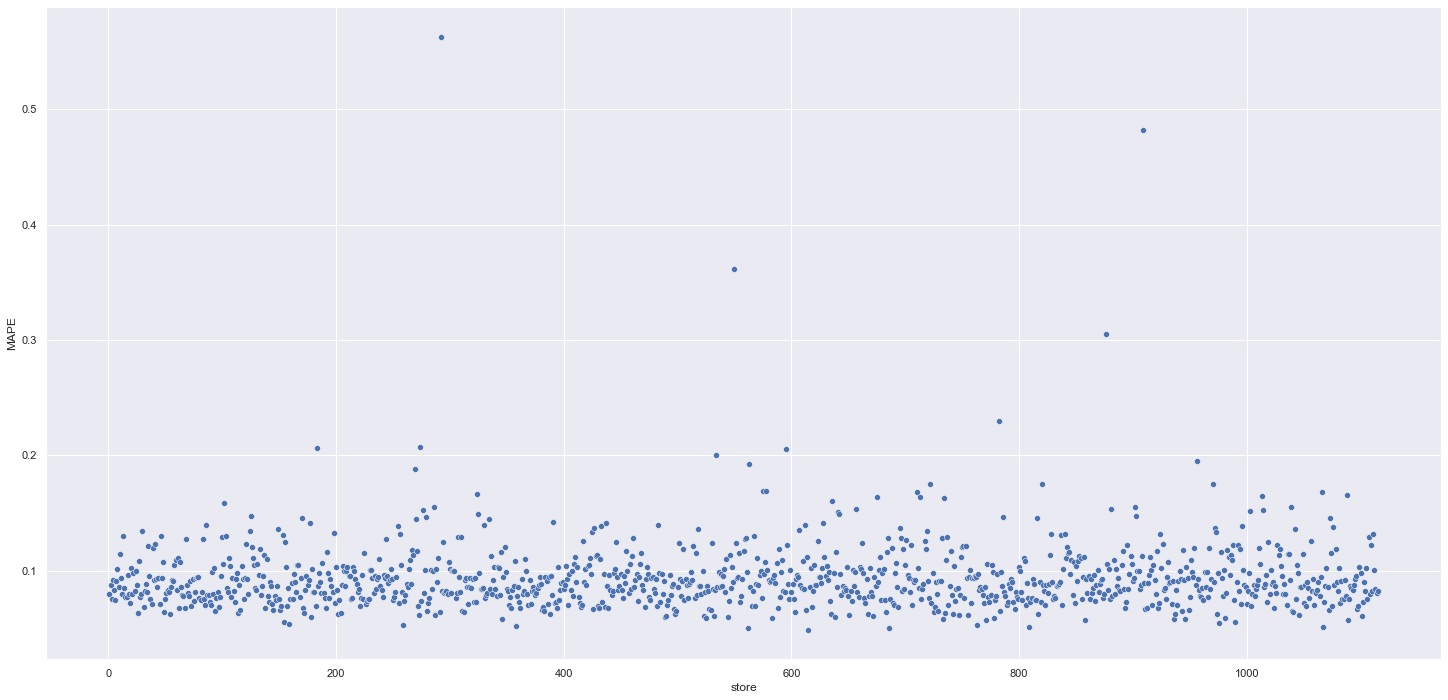

In [99]:
sns.scatterplot(x='store', y='MAPE', data = df92)

### 9.2 Total Performance

In [100]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario',0:'Values'})
df93['Values']= df93['Values'].map('${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"$284,285,248.00"
1,worst_scenario,"$283,554,688.14"
2,best_scenario,"$285,015,893.42"


### 9.3 Machine Learning Performance

<ipython-input-101-e86fd98dd9a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] -df9['predictions']
<ipython-input-101-e86fd98dd9a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with sim

<AxesSubplot:xlabel='predictions', ylabel='error'>

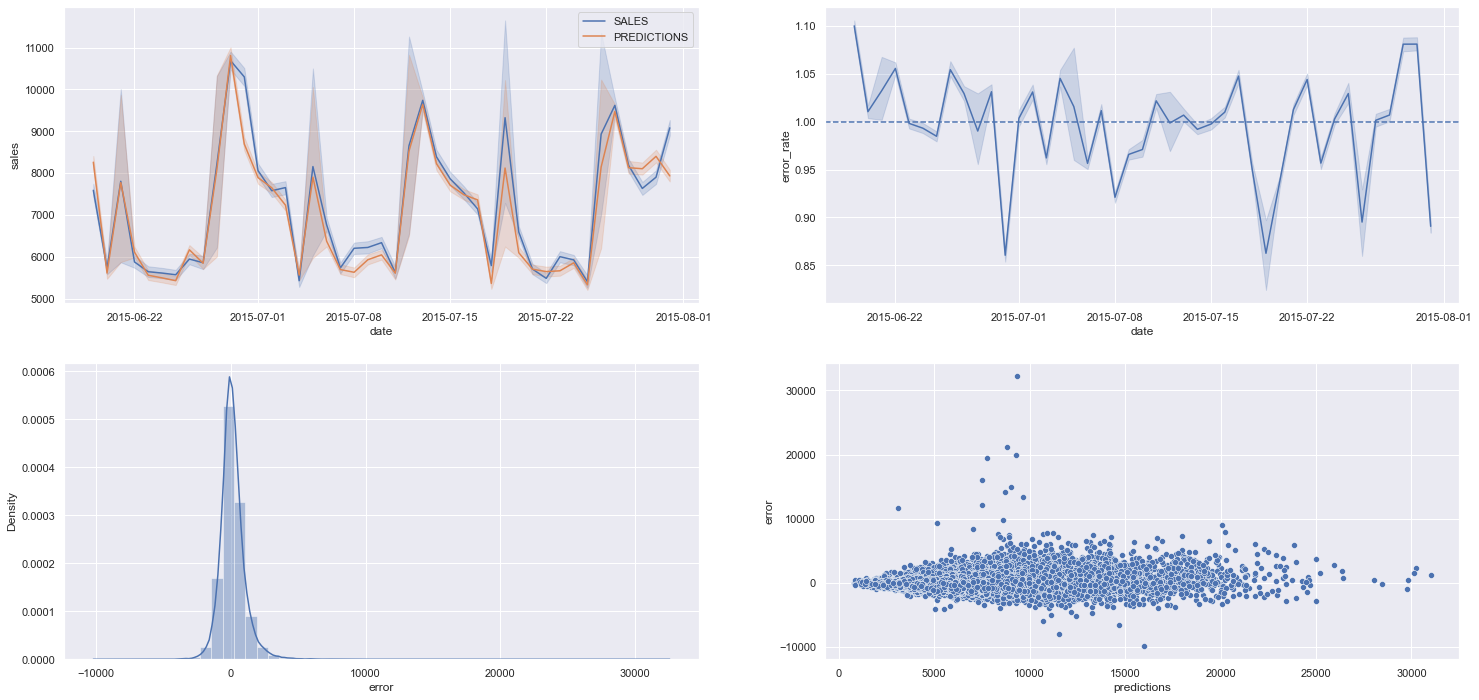

In [101]:
df9['error'] = df9['sales'] -df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])
